# ASG7:
This notebook contains the submission materials for Ian Feekes' submission of Module 7 USD MSAAI Machine Learning fundamentals class. 

If the material in this submission does not meet requirements, please email me at ifeekes@sandiego.edu and I will gratefully and expediently remedy the situation. 

The material for this code should live in the repository here: https://github.com/USD-AAI/aai-510-01-su22-new-ianfeekes-sandiego/tree/main/Module_7

Thank you for taking the time to teach me and to evaluate my work!

## Summary
### Feature Engineering Techniques Used
1) Imputation: certain time-based continuous variables and other highly-correlated variables had values inferred, categorical values had null values set to modes, other continuous variables had values set to mean. Initially for baseline the null values were dropped altogether. 

2) Handling Outliers: windsor technique was applied for days_<> variables to cap outliers on outside of q1 and q3 interval. This was also done for other certain continuous variables. 

3) Categorical encoding/One-hot encoding: This was performed for all ordinal and categorical data, however this was also performed for the baseline evaluation as well.

4) Discretization/Grouping Operators: The observation timeframe variables were grouped together into an obs variable, and the external document variables were grouped into an avgExt variable. 

5) Scaling: A standard scaler is used to normalize several continuous variables during the feature engineering phase. Often this was combined with grouping operators as a function of weighted averages of normalized variables, to differing correlations with the target variable.

6) Feature Creation: home value and home weight are derived from references to loan risk and weighted values from various variables.

### Evaluation Criteria
1) Prediction Accuracy (regular and balanced)

2) Precision Accuracy (regular and average)

#### Findings:
##### Random Forest:
Accuracy of forest: 0.8539055459030559 (baseline was .81)

balanced accuracy score: 0.5334267209782454  (baseline was .31)

average precision score: 0.08907291020238618 (baseline was .03)

precision score: 0.1359615086139997 (baseline was .07)
##### GBT:
Accuracy: 0.16609811967590615 (baseline was .13)
Precision 0.09952045046202843 (baseline was .07)

While the accuracy did not see massive improvements, the precision was significantly higher, and there was much room for tweaking and adding new features as well. 

The GBT shows very marginal improvements, indicating some underlying features worth exploring going into the feature.

#### References:
https://www.projectpro.io/article/8-feature-engineering-techniques-for-machine-learning/423

https://towardsdatascience.com/feature-engineering-for-machine-learning-3a5e293a5114

https://towardsdatascience.com/various-ways-to-evaluate-a-machine-learning-models-performance-230449055f15

### Global Variables
The following cell contains files used for directory organization, global flags, and other useful files

In [1]:
# Global Variables
debug = True                        # Displays additional logging output
savePlots = False                   # Saves plot image files
showCorrelation = False             # Saves information on correlation variablespca = PCA(10)
targetColumnName = "TARGET"         # Name for column denoting dependant variable
outlierThreshold = 3                # Number of standard deviations from which data will be classified as an outlier
dropMissingValues = True #Needs to be true for randomTreeRegressor
plotAllVariables = False            # Plot boxplots and bar plots for the entire dataset - time consuming

# Various file names for debugging and analysis
stringVariablesFile =           './outputFiles/stringVariables.txt'
continuousVariablesFile =       './outputFiles/continuousVariables.txt'
categoricalVariablesFile =      './outputFiles/categoricalVariables.txt'
datasetName =                   './dataset/application_train.csv'
initialDataFileName =           './outputFiles/initialData.txt'
missingValFileName =            './outputFiles/missingValueSummary.txt'
noMissingValuesFileName =       './outputFiles/noMissingValueSummary.txt'
initialDistributionFileName =   './outputFiles/initialDistribution.txt'
dataFrameFileName =             './outputFiles/dataFrameDebug.txt'
generalDebugFileName =          './debug.txt'
testFileName =                  './dataset/application_test.csv'

# Ordinal Data - some are actually categorical but will be processed similarly enough
ordinalColumns = ['FLAG_MOBIL',
               'CODE_GENDER',
               'FLAG_EMP_PHONE',
               'FLAG_WORK_PHONE',
               'FLAG_CONT_MOBILE',
               'FLAG_PHONE',
               'FLAG_EMAIL',
               'FLAG_DOCUMENT_2',
               'FLAG_DOCUMENT_3',
               'FLAG_DOCUMENT_4',
               'FLAG_DOCUMENT_5',
               'FLAG_DOCUMENT_6',
               'FLAG_DOCUMENT_7',
               'FLAG_DOCUMENT_8',
               'FLAG_DOCUMENT_9',
               'FLAG_DOCUMENT_10',
               'FLAG_DOCUMENT_11',
               'FLAG_DOCUMENT_12',
               'FLAG_DOCUMENT_13',
               'FLAG_DOCUMENT_14',
               'FLAG_DOCUMENT_15',
               'FLAG_DOCUMENT_16',
               'FLAG_DOCUMENT_17',
               'FLAG_DOCUMENT_18',
               'FLAG_DOCUMENT_19',
               'FLAG_DOCUMENT_20',
               'FLAG_DOCUMENT_21',
               'LIVE_CITY_NOT_WORK_CITY',
               'NAME_CONTRACT_TYPE',
               'FLAG_OWN_CAR',
               'FLAG_OWN_REALTY',
               'ORGANIZATION_TYPE',
               'REGION_RATING_CLIENT',
               'REG_REGION_NOT_LIVE_REGION',
               'REGION_RATING_CLIENT_W_CITY',
               'LIVE_REGION_NOT_WORK_REGION',
               'REG_CITY_NOT_LIVE_CITY',
               'REG_CITY_NOT_WORK_CITY',
               'EMERGENCYSTATE_MODE'] 

lineString = "---------------------------------------------------------------------------------------------------------"

debugFd = open(generalDebugFileName, "w+")

if debug == True:
    debugFd.write("Global Variables Cell Completed...\n")
    debugFd.write(lineString+"\n")

### Library Inports
The following cell contains various library imports used largely for data frames, data analysis, and plotting. 

In [2]:
# Library Imports
from nis import cat
from re import X
import pandas as pd                 # Used for data frame
import plotly                       # Saves html plots
import plotly.express as px         # Used for displaying plots
import os                           # Allows file manipulation and console debugging for offline jupyter
import numpy as np
from scipy import stats             # Used for outliers
import matplotlib.pyplot as plt     # Used for pyplot heatmap plotting
import seaborn as sns               # Used for showing heatmap
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import linear_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matrix
    # Import the model we are using
from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
from sklearn import metrics #Import scikit-learn metrics module for accuracy calculation

from sklearn.ensemble import RandomForestRegressor
#@TODO: Figure out if we want to delete this or not and use the sklearn tree
from sklearn import tree
from sklearn.datasets import load_iris
import graphviz # Data Tree Visualization

from sklearn.tree import DecisionTreeClassifier # Import Decision Tree Classifier
import pickle                                   # Saving Models
from sklearn.ensemble import RandomForestClassifier

import graphviz # Data Tree Visualization
from sklearn.tree import export_graphviz
from six import StringIO  
from IPython.display import Image  
import pydotplus
import pydot

import phik
from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

if debug == True and debugFd:
    debugFd.write("Library Imports Cell Completed...\n")
    debugFd.write(lineString+"\n")

### Helper Functions
The below cell contains various helper functions, which have descriptions of annotations in their headers. The functions include: 
1) createOutputDirectories - vestigial functions used when I initially did this assignment and saved the plots into files

2) readData - used to read the csv file into a data frame with the target variable and the independent variables

3) dropMissingValues - drops missing values from data frame

4) writeDistribution - writes the distribution of data frame into text file. Used to show that the frequency of target variable is very much unevenly distributed towards more users successfully paying their loans than defaulting.

5) doBar - graphs a bar plot

6) plotColumn - plots an independant variable and determines based on type whether to do bar plot, distro plot, .etc

7) showTargetPlot - similar to writeDistribution, plots the target variable

8) showHeamap - graphs a heatmap of the variables

9) allocateTypes - splits dataframe into dataframes for continuous, categorical, and flags respectively.

10) insert - workaround helper function for writing into a file without overwriting contents.

11) printDataFrame - prints a data frame into a text file for manual analysis, if desired


In [3]:
# Helper Functions

# If the debugging flag is on, creates directories to store output data
#
# Parameters:
# -----------
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# None
#
def createOutputDirectories(debug = False):
    if debug == False:
        return
    if not os.path.exists("images"):
        os.mkdir("images")
    if not os.path.exists("images/initialPlots"):
        os.mkdir("images/initialPlots")
    if not os.path.exists("images/topTenPlots"):
        os.mkdir("images/topTenPlots")
    if not os.path.exists("outputFiles"):
        os.mkdir("outputFiles")
    print("createOutputDirectories...success")


# Reads csv file into data frame and sets independant and dependant variables
#
# Parameters:
# -----------
# @param fileName: string for full relative file path of csv file
# @param dependantVarColumnName: csv file column matching name of column for dependant variable
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# data: dataframe object of csv file reading
# independantVars: independant variables (all data that isn't targetColumnName)
# dependantVar: dependant variable
#
def readData(fileName, dependantVarColumnName = targetColumnName, debug = False):
    independantVars = []
    dependantVar = []
    data = pd.read_csv(fileName)
    index = None
    for i ,col in enumerate(data.columns):
        if col == dependantVarColumnName:
            index = i
    if index != None: 
        dependantVar = data.iloc[:, index]
        independantVars = data.iloc[:]
        independantVars.pop(dependantVarColumnName)
    if debug:
        fd = open(initialDataFileName, "w+")
        fd.write("This file contains the initial data frame without cleaning:\n")
        fd.write(str(data))
        fd.close()
        print("readData...completed")
    return data, independantVars, dependantVar


# Drops rows from dataset which are missing. Prints missing value data for debugging
#
# Parameters:
# -----------
# @param data: dataframe to have missing values dropped and returned
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# data: dataframe object with missing values dropped
#
def dropMissingValues(data, debug = False):
    # Drop missing values
    ret = data.dropna(axis=0)
    # Show number of missing values per independant variable
    if debug:
        fd = open(missingValFileName, "w+")
        fd.write("This data shows the independant variables which contained missing values and the count of each:\n")
        fd.write(str(data.isnull().sum()))
        fd.close()
        fd = open(noMissingValuesFileName, "w+")
        fd.write("This data shows the independant variables which are used for analysis with no mising values:\n")
        fd.write(str(ret.isnull().sum()))
        fd.close()
        print("dropMissingValues...completed")
    return ret


# Writes distribution of data frame to text file
#
# Parameters:
# -----------
# @param data: dataframe to have distribution written to text file
# @param debug: flag for displaying debugger output
#
# Returns:
# ---------
# None
#
def writeDistribution(data, debug = False):
    if debug == False:
        return
    numpy_array = data.to_numpy()
    fd = open(initialDistributionFileName, "w+")
    fd.write(str(numpy_array))
    fd.close()
    print("writeDistribution...success")


def doBar(data, column_name, figsize = (18,6), 
          percentage_display = True,
          plot_defaulter = True, rotation = 0, 
          horizontal_adjust = 0, 
          fontsize_percent = 'xx-small',
          dirName = 'images/initialPlots/'):

    
    print(f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}")
    
    plt.figure(figsize = figsize, tight_layout = False)
    sns.set(style = 'whitegrid', font_scale = 1.2)
    
    #plotting overall distribution of category
    plt.subplot(1,2,1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending = False)
    ax = sns.barplot(x = data_to_plot.index, y = data_to_plot, palette = 'Set1')
    
    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(p.get_x() + horizontal_adjust, p.get_height() + 0.005 * total_datapoints, '{:1.02f}%'.format(p.get_height() * 100 / total_datapoints), fontsize = fontsize_percent)
        
    plt.xlabel(column_name, labelpad = 10)
    plt.title(f'Distribution of {column_name}', pad = 20)
    plt.xticks(rotation = rotation)
    plt.ylabel('Counts')
    
    #plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (data[column_name][data.TARGET == 1].value_counts() * 100 / data[column_name].value_counts()).dropna().sort_values(ascending = False)

        plt.subplot(1,2,2)
        sns.barplot(x = percentage_defaulter_per_category.index, y = percentage_defaulter_per_category, palette = 'Set2')
        plt.ylabel('Percentage of Defaulter per category')
        plt.xlabel(column_name, labelpad = 10)
        plt.xticks(rotation = rotation)
        plt.title(f'Percentage of Defaulters for each category of {column_name}', pad = 20)

    fileName = dirName + column_name + '.png'
    plt.savefig(fileName)


# Plots a column name of the dataframe and saves each plot into a file
#
# Parameters:
# -----------
# @param data:       dataframe to have distribution written to text file
# @param plots:      types of plots for each column to show e.g. "box"
# @param: figsize:   size of figure for matplotlib to plot
# @param: log_scale: flag to log the scale of the plot
#
# Returns:
# ---------
# None
#
def plot_column(data,
                column_name,
                plots = [],
                figsize = (20,8),
                log_scale = False,
                dirName = 'images/initialPlots/'):

    if 'bar' in plots:
        doBar(data, column_name, figsize, dirName = dirName)
        return
    data_to_plot = data.copy()
    plt.figure(figsize = figsize)
    sns.set_style('whitegrid')
    
    for i, ele in enumerate(plots):
        plt.subplot(1, len(plots), i + 1)
        plt.subplots_adjust(wspace=0.25)
        if ele == 'CDF':
            #making the percentile DataFrame for both positive and negative Class Labels
            percentile_values_0 = data_to_plot[data_to_plot.TARGET == 0][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_0['Percentile'] = [ele / (len(percentile_values_0)-1) for ele in range(len(percentile_values_0))]
            
            percentile_values_1 = data_to_plot[data_to_plot.TARGET == 1][[column_name]].dropna().sort_values(by = column_name)
            percentile_values_1['Percentile'] = [ele / (len(percentile_values_1)-1) for ele in range(len(percentile_values_1))]
            
            plt.plot(percentile_values_0[column_name], percentile_values_0['Percentile'], color = 'red', label = 'Non-Defaulters')
            plt.plot(percentile_values_1[column_name], percentile_values_1['Percentile'], color = 'black', label = 'Defaulters')
            plt.xlabel(column_name)
            plt.ylabel('Probability')
            plt.title('CDF of {}'.format(column_name))
            plt.legend(fontsize = 'medium')
            if log_scale:
                plt.xscale('log')
                plt.xlabel(column_name + ' - (log-scale)')
        elif ele == 'distplot':
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 0].dropna(),
                         label='Non-Defaulters', hist = False, color='red')
            sns.distplot(data_to_plot[column_name][data['TARGET'] == 1].dropna(),
                         label='Defaulters', hist = False, color='black')
            plt.xlabel(column_name)
            plt.ylabel('Probability Density')
            plt.legend(fontsize='medium')
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale('log')
                plt.xlabel(f'{column_name} (log scale)')
        elif ele == 'violin':  
            sns.violinplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Violin-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')
        elif ele == 'box':  
            sns.boxplot(x='TARGET', y=column_name, data=data_to_plot)
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale('log')
                plt.ylabel(f'{column_name} (log Scale)')

    fileName = dirName + column_name + '.png'
    plt.savefig(fileName)

    
# Plots distribution of TARGET variable
#
# Parameters:
# -----------
# @param data:   dataframe used for heatmap display
# @param debug:  optional flag for debugging
#
# Returns
# ---------
# None
#
def showTargetPlot(data, debug = False):
    class_dist = data[targetColumnName].value_counts()
    # Plots a Bar chart
    plt.figure(figsize=(12,3))
    plt.title('Distribution of TARGET variable')
    plt.barh(class_dist.index, class_dist.values)
    plt.yticks([0, 1])
    for i, value in enumerate(class_dist.values):
        plt.text(value-2000, i, str(value), fontsize=12, color='white',
                 horizontalalignment='right', verticalalignment='center')
    plt.show()
    # Or if you like pie more
    fig, ax1 = plt.subplots()
    ax1.pie(class_dist.values, labels = ["Successfully Paid off Loan", "Defaulted"])
    ax1.axis('equal')
    ax1.title.set_text("Pie Chart of Target Variable Frequencies")
    plt.show()

    
# Shows heatmap of all variables in data frame argument
#
# Parameters:
# -----------
# @param data:   dataframe used for heatmap display
#
# Returns
# ---------
# None
#
def showHeatmap(data):
    corrmat = data.corr()
    top_corr_features = corrmat.index
    plt.figure(figsize=(20,20))
    plt.title("Heatmap of all Variables")
    #plot heat map
    g=sns.heatmap(data[top_corr_features].corr(),cmap="RdYlGn")
    plt.show()


# Allocates data frames for each data type of argument data frame
#
# Parameters:
# -----------
# @param data:   dataframe to be split into respective types
# @param debug: flag for displaying debugger output of writing columns into respective files
#
# Returns
# ---------
# strTypes           columns of string type
# continuousTypes    columns of continuous variables
# categorical        columns of categorical types
#
def allocateTypes(data, debug = False):
    strTypes = data.select_dtypes(include='object').join(data[targetColumnName])
    continuousTypes = data.select_dtypes(include = ['float64', 'int64'])
    if debug == True:
        fd = open(stringVariablesFile, "w+")
        fd.write("String-type variables:\n")
        fd.write(lineString)
        for col in strTypes.columns: 
            fd.write(col + "\n")
        fd.close()
        fd = open(continuousVariablesFile, "w+")
        fd.write("Continuous-type variables:\n")
        fd.write(lineString)
        for col in continuousTypes.columns: 
            fd.write(col + "\n")
        fd.close()
        print("allocateTypes...success")
    return strTypes, continuousTypes


# Workaround to insert string into file without overwriting contents
#u
# Parameters:
# -----------
# @param originalfile: original file name
# @param string:       string to be written to file
#
# Returns:
# ---------
# None
#
def insert(originalfile,string):
    with open(originalfile,'r') as f:
        with open('newfile.txt','w') as f2: 
            f2.write(string)
            f2.write(f.read())
    os.rename('newfile.txt',originalfile)


# Prints a data frame
#
# Parameters:
# -----------
# @param data: dataframe to be printed
#
# Returns:
# ---------
# None
#
def printDataFrame(data):
    numpy_array = data.to_numpy()
    numpy_array = [i for i in numpy_array if str(i) != 'nan']
    
    try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%d")
    except:
        try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%s")
        except:
            try: np.savetxt(dataFrameFileName, numpy_array, fmt = "%f")
            except: print("error in types")
    
    columnNames = ""
    for i in data.columns:
        columnNames = columnNames + i + " "
    columnNames = columnNames + "\n"
    insert(dataFrameFileName, columnNames)


if debug == True and debugFd:
    debugFd.write("Helper Functions Cell Completed...\n")
    debugFd.write(lineString+"\n")

### Read Data
This creates output directories for debugging and saving plots, if desired, and reads in the data.

In [4]:
# Create output directories for files and plots to be saved to
createOutputDirectories(debug)
# Read the data, assigning independant and dependant variables
data, x, y = readData(datasetName, targetColumnName, debug)

if debug == True and debugFd:
    debugFd.write("Dataset imported...\n")
    debugFd.write(lineString+"\n")

createOutputDirectories...success
readData...completed


### Perform Basic Analysis
The below cell should show a heatmap of the data points and the distribution of the target variable

This shows that the TARGET variable is not evenly distributed

It should also show a heatmap with correlation between various variables. This is useful in that some of the variables have some stronger correlation with the TARGET variable, e.g. EXT_SOURCE1,2,3, APPARTMENTS_AVG, TOTALAREA_MODE, FLOORSMIN_MEDI, and FLOORSMAX_MEDI

Since few variables have high correlations with target, it may be most useful to pick variables that correlate with TARGET (and have lower correlations with eachother, or pick perhaps one of each correlation group, for example a single EXT_SOURCE, a single feature denoting something about the user's real estate data, etc.)

Additionally, some thought should go into selecting independant variables that are missing a significant amount of entries, as shown by the print out of variables with more than 5% null values. 

(307511, 122)
Data Null Values: 
 ---------------------------------------------------------------------------------------------------------
OWN_CAR_AGE                 202929
EXT_SOURCE_1                173378
APARTMENTS_AVG              156061
BASEMENTAREA_AVG            179943
YEARS_BUILD_AVG             204488
COMMONAREA_AVG              214865
ELEVATORS_AVG               163891
ENTRANCES_AVG               154828
FLOORSMIN_AVG               208642
LANDAREA_AVG                182590
LIVINGAPARTMENTS_AVG        210199
LIVINGAREA_AVG              154350
NONLIVINGAPARTMENTS_AVG     213514
NONLIVINGAREA_AVG           169682
APARTMENTS_MODE             156061
BASEMENTAREA_MODE           179943
YEARS_BUILD_MODE            204488
COMMONAREA_MODE             214865
ELEVATORS_MODE              163891
ENTRANCES_MODE              154828
FLOORSMIN_MODE              208642
LANDAREA_MODE               182590
LIVINGAPARTMENTS_MODE       210199
LIVINGAREA_MODE             154350
NONLIVINGAPARTMENTS_

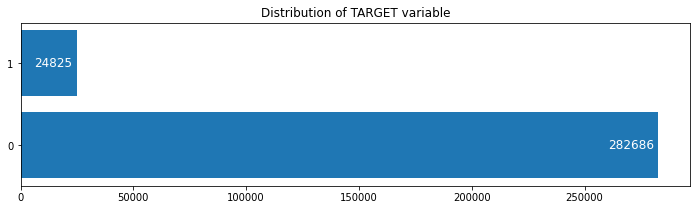

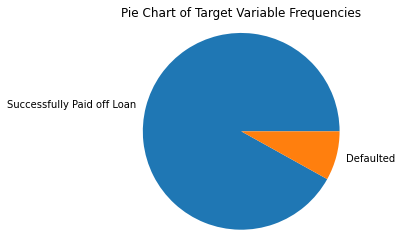

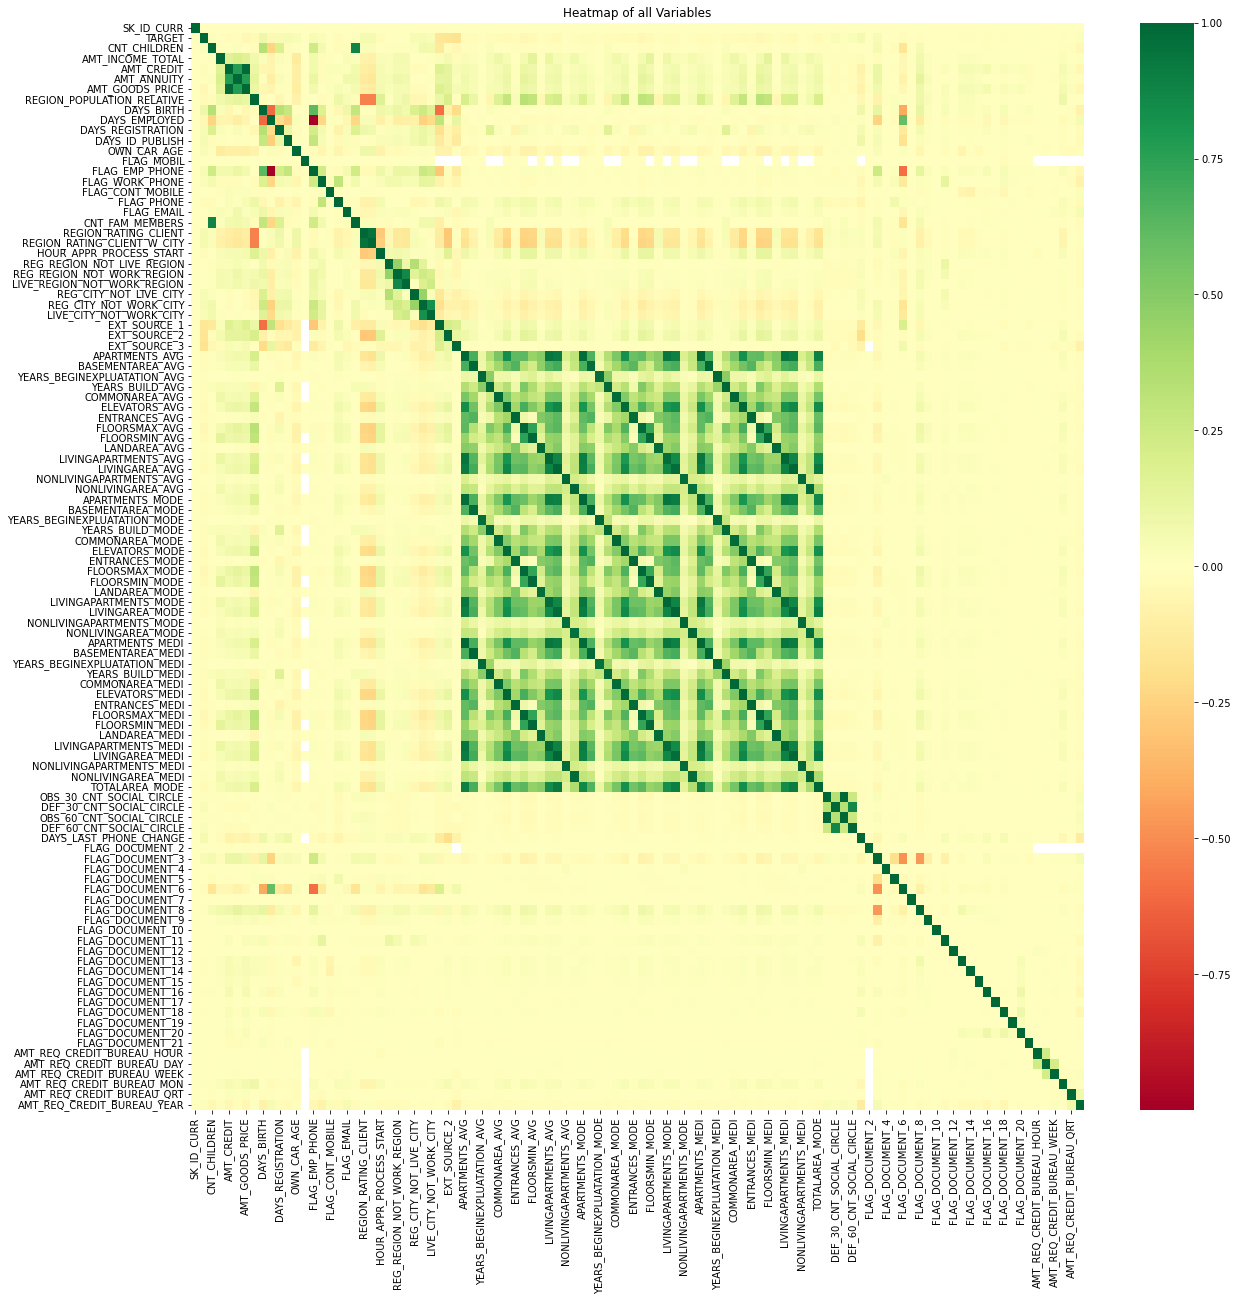

writeDistribution...success


In [5]:
# Shows Entries with more than 50% null values
if debug == True:
    print(data.shape)
    print("Data Null Values: \n", lineString)
    print(data.isnull().sum()[data.isnull().sum() > data.shape[0] * .5])
# Shows distribution of the independant variable, and shows heamap
showTargetPlot(data, debug)
showHeatmap(data)
# Show data distribution and allow for manual analysis of outliers
writeDistribution(data, debug)

if debug == True and debugFd:
    debugFd.write("General Dataset analysis completed...\n")
    debugFd.write(lineString+"\n")

### Splitting the Variables
The following cell splits the data frame up into string type (categorical), continuous, and ordinal variables for cleaner analysis

In [6]:
# Split the data frame into ordinal and non-ordinal since they may not be split necessarily by data-type
data_ordinal = data[ordinalColumns].join(data[targetColumnName])
data_no_ordinals = data.drop(ordinalColumns, axis=1).drop('SK_ID_CURR', axis=1)

## Continuous Variables
Gets summaries for continuous variables: the number of observations, means, min, max, 50th percentile median, stdev


In [7]:
# Get sub-data frames that contain variables from each respective data type
data_strings, data_continuous = allocateTypes(data_no_ordinals, debug)
# Describe should get number of observations, means, min, max, 50th-percentile medians, standard deviations  
for i in data_continuous.columns:
    print(data_continuous[i].describe())
    print(lineString)

allocateTypes...success
count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64
---------------------------------------------------------------------------------------------------------
count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64
---------------------------------------------------------------------------------------------------------
count    3.075110e+05
mean     1.687979e+05
std      2.371231e+05
min      2.565000e+04
25%      1.125000e+05
50%      1.471500e+05
75%      2.025000e+05
max      1.170000e+08
Name: AMT_INCOME_TOTAL, dtype: float64
---------------------------------------------------------------------------------------------------------
count    3.

#### Analysis:
##### CNT_CHILDREN:
The mean and standard deviation make sense, there is an outlier of 19 children which is fairly difficult to explain and drop, so we will probably not remove that outlier. 
##### AMT_INCOME_TOTAL:
There's someone who makes an insane amount of money - it's possible we would want to drop this one. The min income isn't as crazy
##### AMT_CREDIT:
There is a fairly high max, but perhaps not too much of an outlier
##### AMT_ANNUITY:
While the standard deviation is very high here, there are still quite a few outliers both high and low. 
##### AMT_GOODS_PRICE:
Some outliers, but perhaps with feature engineering the data will have a tighter distribution.
##### REGION_POPULATION_RELATIVE
This variable makes sense regarding its values, and may be useful in an aggregate used for regionality hypothesis that rural loanees have a higher defaulting rate.
#### DAYS_BIRTH:
This variable shows some notable correlation with the TARGET variable, but for the sake of sanity should be made positive, and probably just converted to YEARS_BIRTH as well. There are some interesting outliers here as well
#### DAYS_EMPLOYED:
This variable also shows more correlation to the TARGET variable and DAYS_BIRTH as well. It has a negative value which should probably be removed (or set to an average or function of days_birth if the particular data entry has other variables like EMPLOYMENT_TYPE showing it as a good indicator). It also has a crazy max which should be treated likewise.
##### DAYS_REGISTRATION
This variable has some correlation to TARGET and could prove useful while feature engineering as a credit indicator for car payments/responsibility. Should probably be converted to positive years, and have 0 values removed altogether.
##### DAYS_ID_PUBLISH
Similar analysis with DAYS_REGISTRATION above
##### OWN_CAR_AGE: 
Quite a few missing values. Also there's a a 91, so these should be dropped. Shows some interesting correlation with target regarding those who have newer cars making good on their payments.
##### CNT_FAMILY_MEMBERS:
This variable may actually be best represented as a categorical variable. Certainly looking at the boxplot there are fewer cheaper-by-the-dozen family outliers on those who default on their loans (though outlier analysis may be difficult in speculation here). It may even be best to simply do a "1, 2, 3, 4, or 5" family members variable to take a closer look at singles, couples, and small family dynamics and make a "family type" variable. Certainly a scatterplot should be created to look at its peaks.
##### HOUR_APPR_PROCESS_START:
This is garbage, remove it
##### EXT_SOURCE_1
Have very high correlation with TARGET variable but also has quite a few missing values
##### EXT_SOURCE_2
Higher correlation with TARGET variable with fewer missing values
##### EXT_SOURCE_3
Similar to above 2
##### APPARTMENTS_AVG
Has some interesting correlation with TARGET where apartments with larger square footage have slightly lower default rates. It is quite convenient that this is normalized information about the building where the client lives and that very little feature engineering may be required as this information is already quite meaningful.
##### BASEMENT_AREA_AVG
There seems to be very little correlation with TARGET variable. It may be useful as a small parameter in feature engineering regarding approximating a housing value, but also could easily be a candidate for removal in less precise feature engineering simply to reduce dimensionality. 
##### YEARS_BEGIN_EXPLUTATION_AVG
May be best to remove to reduce dimensionality. 
##### YEARS_BUILD_AVG
While intuitively newer houses may add some value to feature engineering for property value of clients, the plots and large data gaps here may be a little messy and it could be best to remove this variable to reduce dimensionality - at least initially.
##### COMMONAREA_AVG
It looks like there is some correlation here between larger common areas and defaulting, similar to appartments_avg. It may be best to simply create this as an aggregate or approximator for appartments_avg with data entries that may be missing one or the other.
##### ELEVATORS_AVG
Similar with common area and appartments avg, it may be best to include this as an aggregate since it seems to have some meaning with regards to the number of elevators in a complex and users defaulting, perhaps as another parameter towards property values.
#####  ENTRANCES_AVG
Similar analysis to ELEVATORS_AVG above.
##### FLOORSMAX_AVG
This describes the number of floors in the building, which is not necessarily easily inferred from the name. It seems to have lower correlation to the target variable. May be best to simply remove in order to reduce dimensionality. We will determine the course of action here after researching a little on biggest parameters towards property value. Note that the FLOORSMAX_MEDI and FLOORSMAX_MODE boxplots with target seem to show quite a bit more promise so certainly this shouldn't be dropped.
##### FLOORSMIN_AVG
This seems to have a little more correlation than with the max number variable. Perhaps they both would be useful in an aggregate, or perhaps the minimum amount of floors in a building when it's an apartment has more meaning than otherwise. 
##### LANDEAREA_AVG
Similar analysis to appartments avg
##### LIVINGAREA_AVG
Similar analysis to common area avg
##### NONLIVINGAPARTMENTS_AVG
This has quite a few missing values and most are quite low, especially since this data is supposed to be averaged. It may be best to simply remove this variable.
##### NONLIVINGAREA_AVG
While intuitively the analysis for the significance of this variable would go hand-in-hand with common-area avg, it has quite a few missing entries and most values are quite low. It may have some use in aggregate/feature engineering for home values, but it also may simply be best to remove it, at least at first.
##### OBS_30_CNT_SOCIAL_CIRCLE
The boxplot of this graph is not particularly useful given that there are many outliers and that most clients are between 0 and 5 counts (a very thin box). It could be useful to blow this up as a categorical variable with valuess 0, 1, 2, 3, 4, 'more than 5'. It is undesirable to abandon this variable since it is quite broad in the set. 
##### OBS_60_CNT_SOCIAL_CIRCLE
This simply has more duration than the first variable, and has similar analysis. These two should probably be formed into some aggregate or feature together. The correlation heatmap for these two is quite high. Similar analysis for DEF_30_CNT_SOCIAL_CIRCLE and DEF_60_CNT_SOCIAL_CIRCLE
##### DAYS_LAST_PHONE_CHANGE
This actually shows some large significance in correlation with target, and relative to the dataset is not missing too many values and should be seen as very noteworthy. Like many of the DAYS variables, it is presented in an ugly way and should be converted to years. This may also have use in some sort of feature engineered for 'recent sketchy behavior'
##### AMT_REQ_CREDIT_BUREAU_HOUR (and Friends)
Similar to the OBS_30_CNT_SOCIAL_CIRCLE, it is difficult to make sense of the boxplot graphs of this variable and it may be best to look at certain timing windows and using the remaining variables for inferences or a feature/aggregate and also looking into the peaks and possibly determining thresholds to use for a categorical feature.


Below we declare continuous variables that we deem of such little meaning that it is best to remove them altogether.

In [8]:
meaninglessContinuousVariables = ['NONLIVINGAPARTMENTS_AVG',
                                  'NONLIVINGAPARTMENTS_MODE',
                                  'NONLIVINGAPARTMENTS_MEDI',
                                  'NONLIVINGAREA_AVG',
                                  'NONLIVINGAREA_MODE',
                                  'NONLIVINGAREA_MEDI',
                                  'HOUR_APPR_PROCESS_START'
]

##### Sketchy Behavior Variables
OBS_30_DEF_SOCIAL_CIRCLE
OBS_60_DEF_SOCIAL_CIRCLE
DAYS_LAST_PHONE_CHANGE
DAYS_ID_PUBLISH

## Categorical/Ordinal Variables:
The cell below produces output for analysis on the categorical and ordinal variables. Some of the things we are most interested in include: 
- Category/Level counts: are they what one expects?
- Tabulation against categorical data: how many samples of each category exist: is the data imbalanced? 
- If so, we should note the variables which are imbalanced to apply certain techniques, where one class is very small in number compared to another class. 
- Identify and report duplicates

In [9]:
print("Ordinal Columns: ")
for i in data_ordinal.columns:
    if True:
        print("Name: ", i)
        print(data_ordinal[i].value_counts())
        #print("Min: ", data_ordinal[i].min())
        #print("Max: ", data_ordinal[i].max())
    print(lineString)
    
print("Categorical Columns: ")
for i in data_strings.columns:
    print(data_strings[i].describe())
    print(data_strings[i].value_counts())
    #print("Min: ", data_strings[i].min())
    #print("Max: ", data_strings[i].max())
    print(lineString)

Ordinal Columns: 
Name:  FLAG_MOBIL
1    307510
0         1
Name: FLAG_MOBIL, dtype: int64
---------------------------------------------------------------------------------------------------------
Name:  CODE_GENDER
F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64
---------------------------------------------------------------------------------------------------------
Name:  FLAG_EMP_PHONE
1    252125
0     55386
Name: FLAG_EMP_PHONE, dtype: int64
---------------------------------------------------------------------------------------------------------
Name:  FLAG_WORK_PHONE
0    246203
1     61308
Name: FLAG_WORK_PHONE, dtype: int64
---------------------------------------------------------------------------------------------------------
Name:  FLAG_CONT_MOBILE
1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64
---------------------------------------------------------------------------------------------------------
Name:  FLAG_PHONE
0    221080
1     8

#### Categorical/Ordinal Variable Analysis: 
##### FLAG_MOBIL
Only has a single false value, can probably be dropped altogether
##### GODE_GENDER
Lots more women than men. Also looking at the bar charts, lots more men tend to default relative to women. Best to remove the unspecified column as well.
##### FLAG_EMP_PHONE
More do have than done. 
##### NAME_INCOME_TYPE
Quite a few Maternity leave and unemployed default on loan, whereas most working, which ist most frequent category occurence, has lower default rate. Also only 5 entries on maternity leave and 22 unemployed so could be worth dropping the statistic. 
##### NAME_EDUCATION_TYPE
Lower secondary has a 2% higher default rate even though it makes up only 1.24% of the variable frequency. Most entries are secondary, followed by higher education and incomplete higher which intuitively makes sense for this variable's distribution. 
##### NAME_FAMILY_STATUS
Should probably remove the 2 'unknown' entries or label them as 'NaN' for ease of data cleaning. The distribution of the categories intuitively makes sense. Interesting that the civil marriage has the highest default rate - perhaps this could be somehow correlated with the fact that these people are not federally supported by the government and may not reap tax benefits from mortgage-related loans. Also widows have a much lower default rate than the rest of the labels in this categorical variable.
##### NAME_HOUSING_TYPE
This variable has an overwhelming number of house/apartment users, which severely imbalances the distribution of the labels. Hopefully something can be done with this variable as it is interesting that The rented apartments and with parent categories have nearly 4% higher default rates, and office apartments have slightly lower rates. It is difficult to speculate because these particular data values have lower frequencies to where overfitting in speculation can become dangerous. 
##### OCCUPATION_TYPE
This variable has 18 labels, nearly half of which are laborers sales staff and core staff. Low-skill laborers at less than 1% of the variable distribution, have a very notable 10% higher default rate than the remainder of the set. High skill tech staff, which does make up a fair chunk of the distribution, is about 3% lower on the default rate. 
##### WEEKDAY_APPR_PROCESS_START
There seems to be very little value presented with this variable. It may be best to simply remove it.
##### FONDKAPREMONT_MODE
75% of this variable is distributed in reg_oper_account. Additionally there is a 'not_specified' column which may as well be set to NaN and removed as it does not add any value to this variable. org_spec_account shows to have a slightly lower (1-2%) default rate than the remaining categories in this variable, but this is fairly marginal, especially given the low frequency and general imablance. 
##### HOUSETYPE_MODE
This variable seems so egregiously imbalanced that it is hard to imagine gleaning any value that is not simply overfitting from it. Likely best to simply remove it. 
##### WALLSMATERIAL_MODE
This variable is also somewhat imbalanced though wooden does make up 4% and has a 2-3% higher default rate and monolithic has a 1-2% lower default rate as well. Also 'others' doesn't really mean anything here so suggest that if this variable does get used, that it simply gets removed. 
##### FLAG_EMP_PHONE
While it is difficult to imagine this variable intuitively having much meaning past another employment indicator, there is an interesting gap between the categories and their TARGET correlation that seems possibly higher than simply overfitting, though it is difficult to glean with 82% to 18% imbalance of sample distribution.
##### FLAG_WORK_PHONE
This is possibly the least-aptly-named variable I have seen in my life and it makes me angry. Looking at the correlation with target, it's difficult to say that it has much meaning. Likely best to remove from the dataset.
##### FLAG_CONT_MOBILE
The 574 entries on the false category and tiny gap between the target variable correlation shows very little value with this variable. Likely best to remove it altogether. 
##### FLAG_PHONE
This variable is fairly imbalanced and has a very marginal difference in distribution in relation to target (and ordinal variables are most subject to overfitting with respect to TARGET and the category distribution) so it likely holds very little value and should be removed from feature evaluation. 
##### FLAG_EMAIL
Likewise with the above, this variable should be removed
##### FLAG_DOCUMENT_2
This is horribly imbalanced and should be removed
##### FLAG_DOCUMENT_3
This has an interesting gap in regards to those who did provide the document, though it is difficult to speculate on correlation given the still somewhat imbalanced distribution, and significant number of empty data entries as well. May be best to remove this variable altogether.
##### FLAG_DOCUMENT_4
Should be removed
##### FLAG_DOCUMENT_5
Should be removed
##### FLAG_DOCUMENT_6
Should be removed
##### FLAG_DOCUMENT_7
Should be removed
##### FLAG_DOCUMENT_8
Should be removed
##### FLAG_DOCUMENT_9
Should be removed
##### FLAG_DOCUMENT_10
Should be removed
##### FLAG_DOCUMENT_11
Should be removed
##### FLAG_DOCUMENT_11
Should be removed
##### FLAG_DOCUMENT_12
Should be removed
##### FLAG_DOCUMENT_13
Should be removed
##### FLAG_DOCUMENT_14
Should be removed
##### FLAG_DOCUMENT_15
Should be removed
##### FLAG_DOCUMENT_16
Should be removed
##### FLAG_DOCUMENT_17
Should be removed along with documents through 21
##### LIVE_CITY_NOT_WORK_CITY
Fairly imbalanced variable, however the 20% who commute from away from the city to have a 2.5% higher default rate so this variable may have some meaning, especially if used in feature engineering. 
##### NAME_CONTRACT_TYPE
This variable is terribly imbalanced, but does show a 3% difference higher in cash loans defaulting compared to revolving, so it may provide some value if added into a feature or aggregate. 
##### FLAG_OWN_CAR
This variable is slightly imbalanced and is missing quite a few entries, however it still has a slight gap in those who do not own a car defaulting. 
##### FLAG_OWN_REALTY
Similar to FLAG_OWN_CAR but slightly more imbalance and a slightly smaller gap. Perhaps these two should fall into some aggregate. 
##### FLAG_ORGANIZATION_TYPE
This variable shows quite some interesting meaning though it has XNA and Other, which should be removed or set to NaN. A large amount of the data is distributed among the remaining variables, however there is still some interesting values in Industry type 8 and industry type 2. This may have higher use as an aggregate, but encoding this categorical variable would otherwise be a nightmare in regards to dimensionality.
##### EMERGENCYSTATE_MODE
Should be deleted

Categorical/Ordinal variables deemed from this analysis to be of insignificant value to the dataset are declared below:

In [10]:
meaninglessCategoricalVariables = [
    'EMERGENCYSTATE_MODE',
    'FLAG_DOCUMENT_2',
    'FLAG_DOCUMENT_3',
    'FLAG_DOCUMENT_4',
    'FLAG_DOCUMENT_5',
    'FLAG_DOCUMENT_6',
    'FLAG_DOCUMENT_7',
    'FLAG_DOCUMENT_8',
    'FLAG_DOCUMENT_9',
    'FLAG_DOCUMENT_10',
    'FLAG_DOCUMENT_11',
    'FLAG_DOCUMENT_12',
    'FLAG_DOCUMENT_13',
    'FLAG_DOCUMENT_14',
    'FLAG_DOCUMENT_15',
    'FLAG_DOCUMENT_16',
    'FLAG_DOCUMENT_17',
    'FLAG_DOCUMENT_18',
    'FLAG_DOCUMENT_19',
    'FLAG_DOCUMENT_20',
    'FLAG_DOCUMENT_21',
    'FLAG_EMAIL',
    'FLAG_PHONE',
    'FLAG_CONT_MOBILE',
    'FLAG_WORK_PHONE',
    'HOUSETYPE_MODE',
    'WEEKDAY_APPR_PROCESS_START',
    'FLAG_MOBIL'
]

### Plotting All Variables
The below cell splits the variables into appropriate values, and plots all of them, saving the plots into the images directory for manual analysis.

#### Warning: Running this cell will plot all variables and consume quite a lot of CPU/GPU resources

In [11]:
if plotAllVariables == True:
    for i in data_strings.columns:
        plot_column(data_strings, i, ['bar'])
    for i in data_ordinal.columns:
        plot_column(data_ordinal, i, ['bar'])
    for i in data_continuous.columns:
        plot_column(data_continuous, i, ['box'])

### Showing Correlations
The following block outputs the top 10 independant variables correlated with data. They also have high correlation amongst themselves as well (the EXT_SOURCE credits, some DAYS time-related variables, and some REGION area-related variables.). 

In [12]:
print("Top 30 Variables correlated with TARGET")
print(lineString)
# Just show 11 for now rather than removing target
print(data.corr()['TARGET'].abs().sort_values(ascending = False).head(31))

Top 30 Variables correlated with TARGET
---------------------------------------------------------------------------------------------------------
TARGET                         1.000000
EXT_SOURCE_3                   0.178919
EXT_SOURCE_2                   0.160472
EXT_SOURCE_1                   0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
REG_CITY_NOT_WORK_CITY         0.050994
FLAG_EMP_PHONE                 0.045982
DAYS_EMPLOYED                  0.044932
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_DOCUMENT_3                0.044346
FLOORSMAX_AVG                  0.044003
FLOORSMAX_MEDI                 0.043768
FLOORSMAX_MODE                 0.043226
DAYS_REGISTRATION              0.041975
AMT_GOODS_PRICE                0.039645
OWN_CAR_AGE                    0.037612
REGION_POPULATION_RELATIVE     0.037227
ELEVATORS_AVG 

### Remove Meaningless Categorical Variables
These variables have very little value and are removed to reduce dimensionality, especially given one-hot-encoding and categorical variables

In [13]:
# Drop the meaningless categorical variables declared several cells above, display info for debugging use
numVars = data.shape[1]
try: 
    data = data.drop(meaninglessCategoricalVariables, axis = 1)
except:
    if debug == True:
        print("Categorical variables of insignificance have already been dropped from data frame")
if debug == True:
    print(abs(numVars - data.shape[1]), 
          "categorical variables of little meaning have been dropped from the data frame.",
          data.shape[1],
          "variables now remain in the data frame")

28 categorical variables of little meaning have been dropped from the data frame. 94 variables now remain in the data frame


### Remove Meaningless Continuous Variables
These variables have very value and are removed to reduce dimensionality.

In [14]:
# Drop the meaningless continuous variables declared several cells above, display info for debugging use
numVars = data.shape[1]
try: 
    data = data.drop(meaninglessContinuousVariables, axis = 1)
except:
    if debug == True:
        print("Continuous variables of insignificance have already been dropped from data frame")
if debug == True:
    print(abs(numVars - data.shape[1]), 
          "continuous variables of little meaning have been dropped from the data frame.",
          data.shape[1],
          "variables now remain in the data frame")

7 continuous variables of little meaning have been dropped from the data frame. 87 variables now remain in the data frame


## Variable Cleaning

#### Data Imbalances
According to Google Developers, imbalance threshold can be defined in 3 degrees:
1) Mild (20-40%)
2) Moderate (1-20%)
3) Extreme (<1%)

This is important to clean up because if we have an imbalance (say an ordinal with 90% vs 10%, then the former's performance will count 9 times as much as the performance of minority class examples

### Showing Variables with Imbalances

In [15]:
# Initialize maps mapping variables with severity of particular category imbalances
mild = {}
moderate = {}
extreme = {}

# Function that given a data frame and emtpy maps for mild, moderate, and extreme
# will fill the maps with variable to category mappings for analysis purposes
def allocateSeverity(df, mild, moderate, extreme):
    for i in df.columns:
        # Ignore dropped columns
        if i not in data.columns: 
            continue
        # Get value counts data structure
        valueCounts = df[i].value_counts()
        # Extract category names into a variable for easier iteration
        categoryNames = valueCounts.index.tolist()
        for idx, category in enumerate(valueCounts):
            if category/sum(valueCounts) < .01:
                extreme[i] = valueCounts
            elif category/sum(valueCounts) < .2:
                moderate[i] = valueCounts
            elif category/sum(valueCounts) < .4:
                mild[i] = valueCounts

                
# Prints details on a value count for the category, number of occurences, and its % of the variable                
def printCategoryDetails(valueCount):
    categoryNames = valueCount.index.tolist()
    for idx, val in enumerate(valueCount):
        print(categoryNames[idx], val, " Weight on dataset: ", val/sum(valueCount))

# Calls helper function at top of the block to allocate mappings
allocateSeverity(data_ordinal, mild, moderate, extreme)
allocateSeverity(data_strings, mild, moderate, extreme)

# Prints information from which categories are extreme, moderate, and mild with imbalances
if debug == True:
    print(len(extreme.keys()),"Extreme items: ")
    for key, value in extreme.items():
        print(lineString)
        print("Variable: ", key)
        printCategoryDetails(extreme[key])
    print("\n"*3)
    print(len(moderate.keys()),"Moderate items: ")
    for key, value in moderate.items():
        print(lineString)
        print("Variable: ", key)
        printCategoryDetails(moderate[key])
    print("\n"*3)
    print(len(mild.keys()), "Mild items: ")
    for key, value in mild.items():
        print(lineString)
        print("Variable: ", key)
        printCategoryDetails(mild[key])


8 Extreme items: 
---------------------------------------------------------------------------------------------------------
Variable:  CODE_GENDER
F 202448  Weight on dataset:  0.6583439291602576
M 105059  Weight on dataset:  0.34164306317497584
XNA 4  Weight on dataset:  1.3007664766463638e-05
---------------------------------------------------------------------------------------------------------
Variable:  ORGANIZATION_TYPE
Business Entity Type 3 67992  Weight on dataset:  0.22110428570034893
XNA 55374  Weight on dataset:  0.18007160719453938
Self-employed 38412  Weight on dataset:  0.12491260475235032
Other 16683  Weight on dataset:  0.05425171782472822
Medicine 11193  Weight on dataset:  0.03639869793275688
Business Entity Type 2 10553  Weight on dataset:  0.034317471570122694
Government 10404  Weight on dataset:  0.03383293605757193
School 8893  Weight on dataset:  0.028919290692040286
Trade: type 7 7831  Weight on dataset:  0.02546575569654419
Kindergarten 6880  Weight on datase

### Fixing Extreme Variable Imbalances
The output above shows that we have 2 extreme items: code_gender and organization type. CODE_GENDER suffers because there are 4 XNA values, which should be treated as NaN. 
ORGANIZATION_TYPE has many, many categories and most of the weight is in 3: XNA which should be treated NaN as with CODE_GENDER. Self-employed represents 12.5%, Business Entity Type 3 represents 22%, and "Other" represents 5% and should probably be set to NaN for now since it isn't particularly meaningful. Additionally, it is difficult to get meaning from the type x variables in organization type, so for now it may be best to simply aggregate them and group them by industry.

#### Setting bad categories to NaN

In [16]:
# Determine categorical variables of interest
categoricalColumns = []
for i in list(data_ordinal.columns) + list(data_strings.columns):
    if i in data.columns:
        categoricalColumns.append(i)

# Sets XNA values in data's given column to NaN
def setNaN(val, columnName):
    if columnName not in data.columns:
        return
    data[columnName] = np.where(data[columnName] == val, np.NaN, data[columnName])

# All of our categorical columns should have stupid values taken out
for i in categoricalColumns:
    numNan = data.isnull().sum()[i]
    setNaN('XNA', i)
    setNaN('Other', i)
    setNaN('Unknown', i)
    if debug == True and data.isnull().sum()[i]-numNan > 0:
        print(data.isnull().sum()[i]-numNan,"entries deleted for",i)
        print(lineString, "\n")
    
# Make sure gender is now ordinal
assert(data['CODE_GENDER'].value_counts().count()== 2)

# Make sure the code breaks if any remaining entries have these bad values
for i in data.columns:
    for entry in data[i]:
        assert(not(entry == 'Other'))
        assert(not(entry == 'XNA'))

4 entries deleted for CODE_GENDER
--------------------------------------------------------------------------------------------------------- 

72057 entries deleted for ORGANIZATION_TYPE
--------------------------------------------------------------------------------------------------------- 

2 entries deleted for NAME_FAMILY_STATUS
--------------------------------------------------------------------------------------------------------- 



KeyboardInterrupt: 

#### Aggregating ORGANIZATION_TYPE categories by industry

Business Entity        156586
Self-employed           38412
Trade                   14315
Industry                14311
Medicine                11193
Government              10404
Transport                8990
School                   8893
Kindergarten             6880
Construction             6721
Security                 3247
Housing                  2958
Military                 2634
Bank                     2507
Agriculture              2454
Police                   2341
Postal                   2157
Security Ministries      1974
Restaurant               1811
Services                 1575
University               1327
Hotel                     966
Electricity               950
Insurance                 597
Telecom                   577
Emergency                 560
Advertising               429
Realtor                   396
Culture                   379
Mobile                    317
Legal Services            305
Cleaning                  260
Religion                   85
Name: ORGA

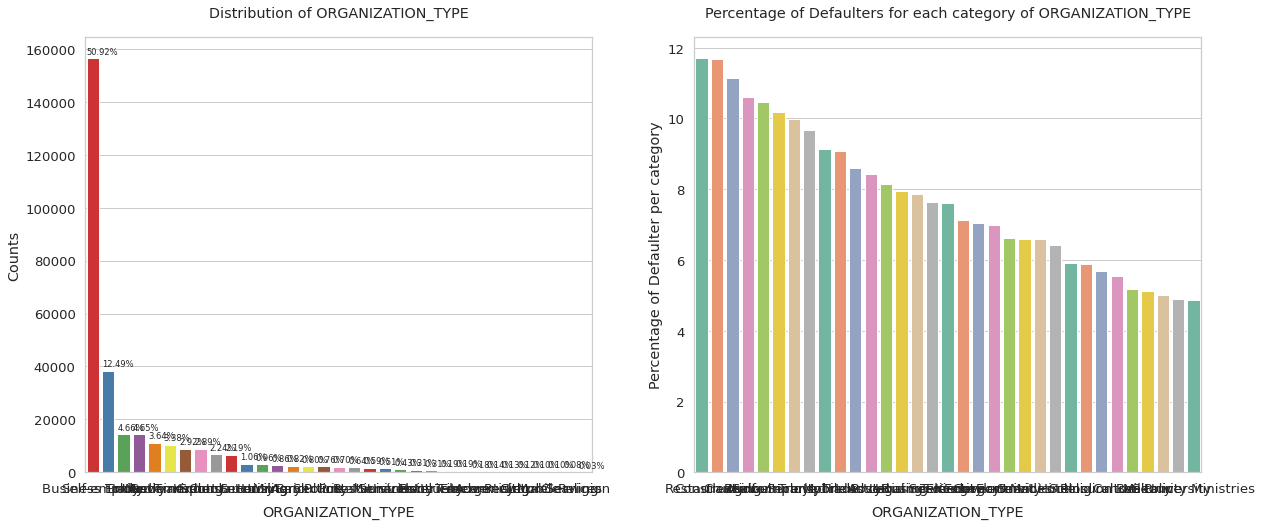

In [ ]:
# Define list of groups with "type" in organization type variable
industryGroups = [
    'Business Entity',
    'Trade',
    'Industry',
    'Transport',
]

# Categories starting with a string in a given column are set to that string
def doGroup(string, column):
    data[column] = np.where(data[column].str.startswith(string), string, data[column])

# Set all 'type' groups to a more generalized industry group
for i in industryGroups:
    doGroup(i, 'ORGANIZATION_TYPE')

# Show categories of organization type and plot new variable
if debug == True:
    print(data['ORGANIZATION_TYPE'].value_counts())
    plot_column(data, 'ORGANIZATION_TYPE', ['bar'])


#### Converting Ordinal Data to Binary
Here we are doing this specifically for flags and columns with only two categories. Each ordinal variable will be converted to the first category represented as a 1 true, 0 false. This is done to minimize dimensionality.

In [ ]:
# Shape should not be changing
prevShape = data.shape

excludeColumns = [
    'ORGANIZATION_TYPE',
    'REGION_RATING_CLIENT',
    'REGION_RATING_CLIENT_W_CITY',
    'TARGET'
]

# Create column list we are interested in
tempColumns = []
for i in data_ordinal.columns:
    if i not in excludeColumns:
        tempColumns.append(i)

tempCategorical = []
        
# Iterate through desired columns, convert to binary, retain dimensionality
for i in tempColumns:
    if i in data.columns:
        dummies = pd.get_dummies(data[i], drop_first = True)
        colName = i+"_"+str(dummies.columns[0]).split('.')[0]
        data[colName] = dummies
        tempCategorical.append(colName)
        data.drop(i, axis = 1, inplace = True)

# No new columns should be added to the data frame: break the code if this is not the case
assert(data.shape == prevShape)

#### Setting Categorical Column NaN values to Mode

In [ ]:
tempCategoricalColumns = []
for i in categoricalColumns:
    if i in data.columns and not (i == 'TARGET'):
        tempCategoricalColumns.append(i)
for i in tempColumns:
    if i in data.columns and not (i == 'TARGET'):
        tempCategoricalColumns.append(i)
categoricalColumns = tempCategoricalColumns

data[categoricalColumns] = data[categoricalColumns].fillna(data.mode().iloc[0])
print("Categorical Columns which should now all have 0 null values: ")
print(data.isnull().sum()[categoricalColumns])

Categorical Columns which should now all have 0 null values: 
ORGANIZATION_TYPE              0
REGION_RATING_CLIENT           0
REGION_RATING_CLIENT_W_CITY    0
NAME_TYPE_SUITE                0
NAME_INCOME_TYPE               0
NAME_EDUCATION_TYPE            0
NAME_FAMILY_STATUS             0
NAME_HOUSING_TYPE              0
OCCUPATION_TYPE                0
FONDKAPREMONT_MODE             0
WALLSMATERIAL_MODE             0
dtype: int64


#### Dropping Organization Type
Even though this variable was part of my top 10 variables originally, it has such high dimensionality that for the sake of time it should be removed here.

In [ ]:
# Drop it if it's in there
if 'ORGANIZATION_TYPE' in data.columns:
    data.drop('ORGANIZATION_TYPE', axis = 1, inplace = True)
# Spit out an error to break notebook execution if it's still in there.
assert('ORGANIZATION_TYPE' not in data.columns)

#### Label Encoding Remaining Categorical Variables

### Fixing Moderate Variable Imbalances

In [ ]:
# import sampling and other necessary libraries 
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# define pipeline
model = SVC()
over = SMOTE(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under), ('model', model)]
pipeline = Pipeline(steps=steps)

# import libraries for evaluation
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from numpy import mean

data2 = data.dropna(axis = 1)

target = data2[targetColumnName]
tempCategoricalDF = data2[tempCategorical]
assert(target.shape[0] == tempCategoricalDF.shape[0])

X = target
y = tempCategoricalDF

### Would have liked to implement the below but ran out of time
"""
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)

# summarize class distribution
print("Before oversampling: ",Counter(y_train))

# define oversampling strategy
SMOTE = SMOTE()

# fit and apply the transform
X_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)

# summarize class distribution
print("After oversampling: ",Counter(y_train_SMOTE))

#PART 2
# import SVM libraries 
from sklearn.svm import SVC
from sklearn.metrics import classification_report, roc_auc_score

model=SVC()
clf_SMOTE = model.fit(X_train_SMOTE, y_train_SMOTE)
pred_SMOTE = clf_SMOTE.predict(X_test)

print("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_SMOTE))

    
scores = cross_val_score(pipeline,
                         target,
                         tempCategoricalDF,
                         scoring='roc_auc',
                         cv=5,
                         n_jobs=-1)
score = mean(scores)
print('ROC AUC score for the combined sampling method: %.3f' % score)
"""


'\nX_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30)\n\n# summarize class distribution\nprint("Before oversampling: ",Counter(y_train))\n\n# define oversampling strategy\nSMOTE = SMOTE()\n\n# fit and apply the transform\nX_train_SMOTE, y_train_SMOTE = SMOTE.fit_resample(X_train, y_train)\n\n# summarize class distribution\nprint("After oversampling: ",Counter(y_train_SMOTE))\n\n#PART 2\n# import SVM libraries \nfrom sklearn.svm import SVC\nfrom sklearn.metrics import classification_report, roc_auc_score\n\nmodel=SVC()\nclf_SMOTE = model.fit(X_train_SMOTE, y_train_SMOTE)\npred_SMOTE = clf_SMOTE.predict(X_test)\n\nprint("ROC AUC score for oversampled SMOTE data: ", roc_auc_score(y_test, pred_SMOTE))\n\n    \nscores = cross_val_score(pipeline,\n                         target,\n                         tempCategoricalDF,\n                         scoring=\'roc_auc\',\n                         cv=5,\n                         n_jobs=-1)\nscore = mean(scores)\nprint(\'RO

### Days_<>
Many of the DAYS_ columns are presented in an unfortunate way. It is best presented if they are positive values, perhaps represented in years for easy manual intuition/analysis. Afterwards, some outliers will be removed as well.

#### Creating 'Years' from Days:
The below snippet creates a mapping for names between the days variables and creates corresponding years variables represented with positive floating points for years, much nicer.

In [ ]:
# Declare Mapping list of days variables to look at and new names to give them
daysColumnsMapping = {'DAYS_BIRTH': 'YEARS_BIRTH',
                      'DAYS_EMPLOYED': 'YEARS_EMPLOYED',
                      'DAYS_REGISTRATION': 'YEARS_REGISTRATION',
                      'DAYS_ID_PUBLISH': 'YEARS_ID_PUBLISH',
                      'DAYS_LAST_PHONE_CHANGE': 'YEARS_LAST_PHONE_CHANGE'}
# Iterate through mappings displaying old features and new features
for key, val in daysColumnsMapping.items():
    if key in data.columns:
        # Describe baseline column
        print(data[key].describe(), "\n", end = lineString+"\n", sep = "\n")
        # Create newer, shinier column, insert it, and remove the old one
        newCol = round(abs(data[key]) / (365))
        if val not in data.columns:
            data.insert(len(data.columns), val, newCol.values)
        elif debug == True:
            print("Already added column", val, "to data frame")
        data = data.drop(key, axis = 1)
        # Describe newer column
        print(data[val].describe(), "\n", end = lineString+"\n", sep = "\n")
    else:
        # Should probably know if trying to manipulate dataframe on nonexistent column
        print("Warning: ", key, " is not among the variables in the current data frame!")

count    307511.000000
mean     -16036.995067
std        4363.988632
min      -25229.000000
25%      -19682.000000
50%      -15750.000000
75%      -12413.000000
max       -7489.000000
Name: DAYS_BIRTH, dtype: float64

---------------------------------------------------------------------------------------------------------
count    307511.000000
mean         43.938646
std          11.964047
min          21.000000
25%          34.000000
50%          43.000000
75%          54.000000
max          69.000000
Name: YEARS_BIRTH, dtype: float64

---------------------------------------------------------------------------------------------------------
count    307511.000000
mean      63815.045904
std      141275.766519
min      -17912.000000
25%       -2760.000000
50%       -1213.000000
75%        -289.000000
max      365243.000000
Name: DAYS_EMPLOYED, dtype: float64

---------------------------------------------------------------------------------------------------------
count    307511.000000
m

#### Displaying Years Outliers
Find outliers will find all rows for a column in the dataframe that fit statistical definitions of outliers. This block of code iterates through this and displays the outliers if desired.

In [ ]:
def find_outliers(df):
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    iqr=q3-q1
    outliers = df[((df<(q1-1.5*iqr)) | (df>(q3+1.5*iqr)))]
    return outliers

for key, val in daysColumnsMapping.items():
    if val in data.columns:
        outliers = find_outliers(data[val])
        if debug == True:
            print("Variable:", val)
            print("Mean:",data[val].mean())
            print("Number of entries: ", len(data[val])-data.isnull().sum()[val])
            print("Number of missing values: ", data.isnull().sum()[val])
            print("Number of outliers:",len(outliers))
            print("Lower quantile:", data[val].quantile(0.25))
            print("Higher quantile:", data[val].quantile(0.75))
            print(outliers,"\n", end = lineString+"\n")
            
#print("Data Null Values: \n", lineString)
#print(data.isnull().sum()[data.isnull().sum() > data.shape[0] * .5])
#print(data.isnull().sum()[data.isnull().sum() > 0])

Variable: YEARS_BIRTH
Mean: 43.93864609721278
Number of entries:  307511
Number of missing values:  0
Number of outliers: 0
Lower quantile: 34.0
Higher quantile: 54.0
Series([], Name: YEARS_BIRTH, dtype: float64) 
---------------------------------------------------------------------------------------------------------
Variable: YEARS_EMPLOYED
Mean: 185.608020526095
Number of entries:  307511
Number of missing values:  0
Number of outliers: 56289
Lower quantile: 3.0
Higher quantile: 16.0
8         1001.0
11        1001.0
23        1001.0
38        1001.0
43        1001.0
           ...  
307469    1001.0
307483    1001.0
307487    1001.0
307505    1001.0
307507    1001.0
Name: YEARS_EMPLOYED, Length: 56289, dtype: float64 
---------------------------------------------------------------------------------------------------------
Variable: YEARS_REGISTRATION
Mean: 13.659439824916833
Number of entries:  307511
Number of missing values:  0
Number of outliers: 1081
Lower quantile: 6.0
Higher 

### Cleaning Years Outliers & Missing Values
As seen from the cell above, there is only a single missing value in any of the columns - one from YEARS_LAST_PHONE_CHANGE which we will simply drop for now. 

Since all of these variables only have a cumulative total of a single missing value, they are incredibly robust, and as such will have 5%-95% outliers set to the respective high and low quantiles in Windsorization.

In [ ]:
# Copies dataframe column, sets outlier values to limits and returns
def windsorize_column(df):
    newCol = df.copy()
    q1=df.quantile(0.25)
    q3=df.quantile(0.75)
    iqr=q3-q1
    for idx, val in enumerate(newCol):
        if val < (q1 - 1.5 * iqr):
            newCol[idx] = q1 - 1.5 * iqr
        elif val > (q3 + 1.5 * iqr):
            newCol[idx] = q3 + 1.5 * iqr
    return newCol

# Iterate through years columns and windsorize the desired bounds to clean outliers
for key, val in daysColumnsMapping.items():
    prevOutliers = len(find_outliers(data[val]))
    data[val] = windsorize_column(data[val])
    currOutliers = len(find_outliers(data[val]))
    # Print difference in number of outliers if desired
    if debug == True:
        print(val, "previously had", prevOutliers, "outliers. Now has",currOutliers,"outliers")
        print(lineString)

YEARS_BIRTH previously had 0 outliers. Now has 0 outliers
---------------------------------------------------------------------------------------------------------
YEARS_EMPLOYED previously had 56289 outliers. Now has 0 outliers
---------------------------------------------------------------------------------------------------------
YEARS_REGISTRATION previously had 1081 outliers. Now has 0 outliers
---------------------------------------------------------------------------------------------------------
YEARS_ID_PUBLISH previously had 0 outliers. Now has 0 outliers
---------------------------------------------------------------------------------------------------------
YEARS_LAST_PHONE_CHANGE previously had 3566 outliers. Now has 0 outliers
---------------------------------------------------------------------------------------------------------


### Plotting Cleaned Years Variables
From this we see that YEARS_LAST_PHONE_CHANGE is pretty useless so we want to remove it for now.

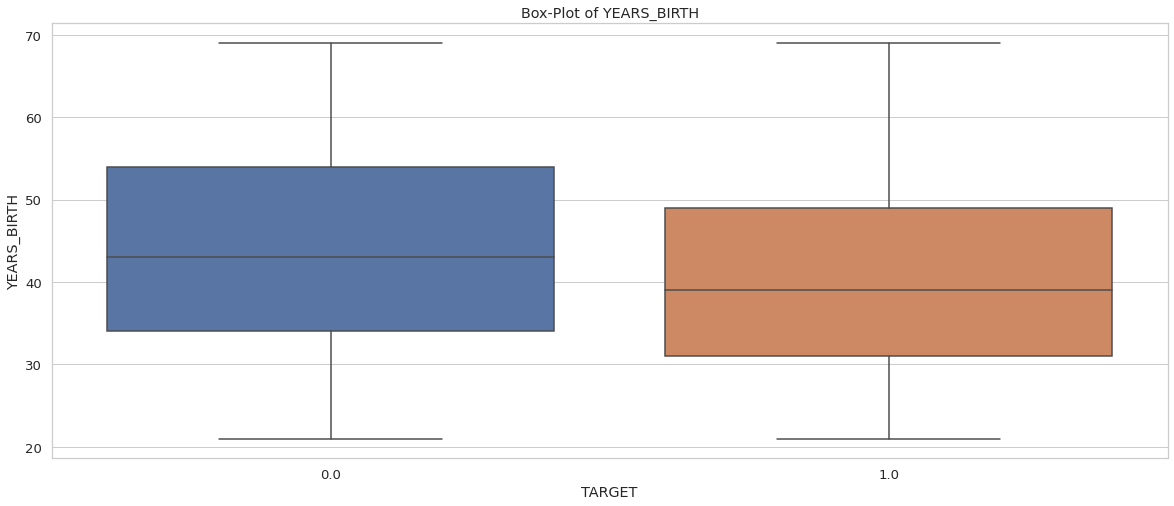

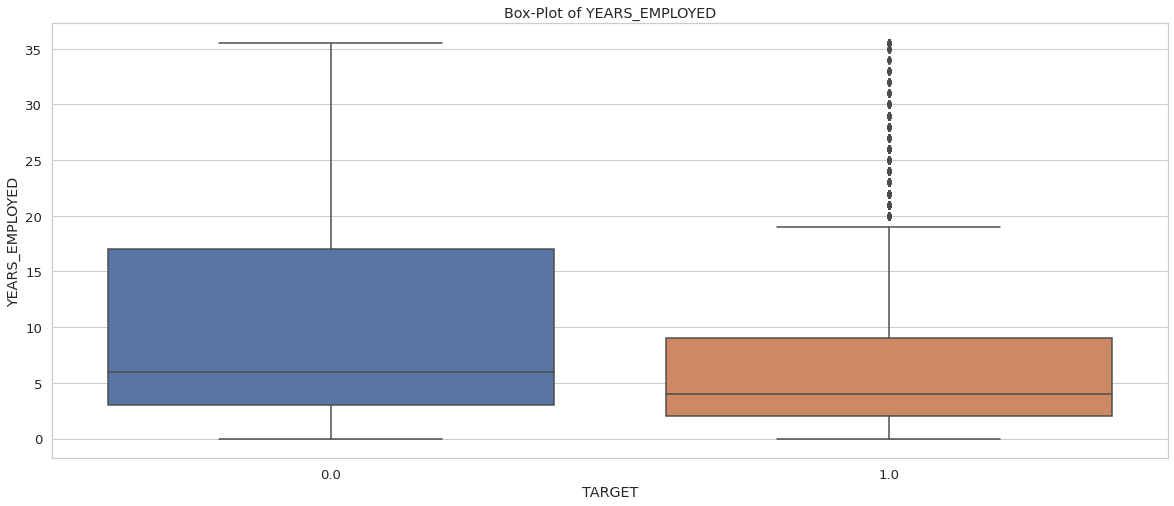

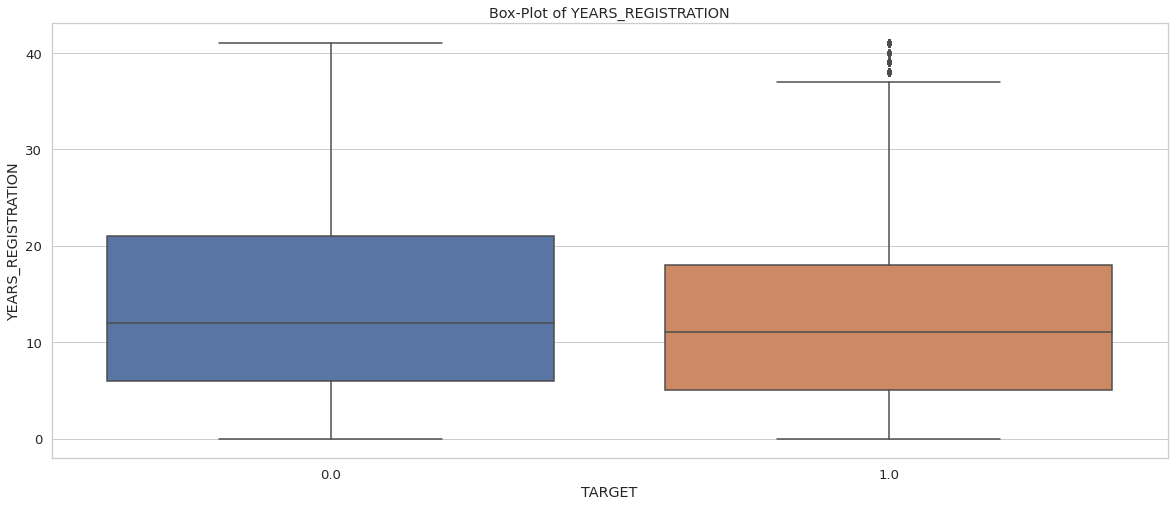

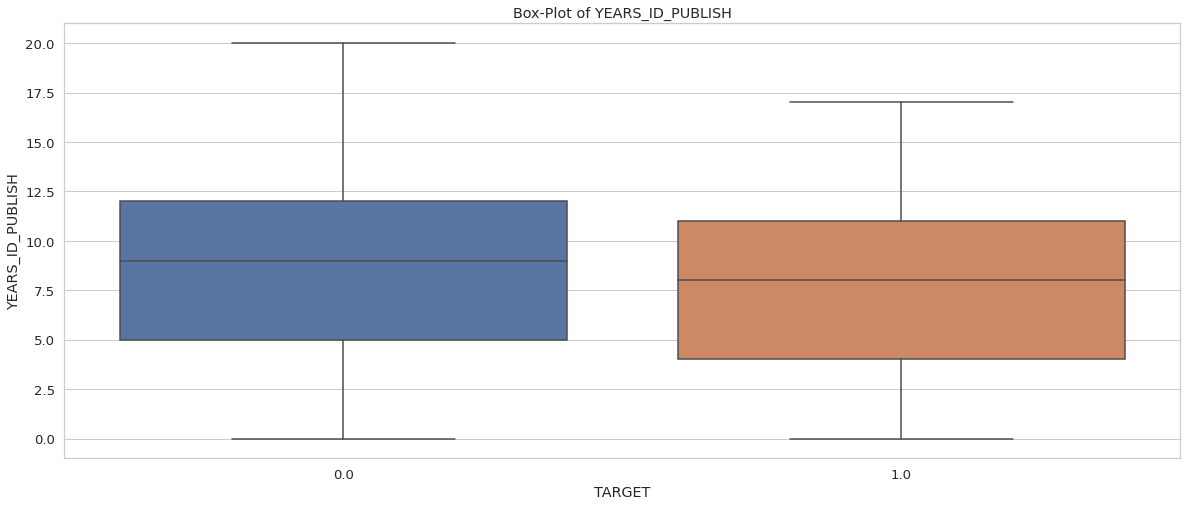

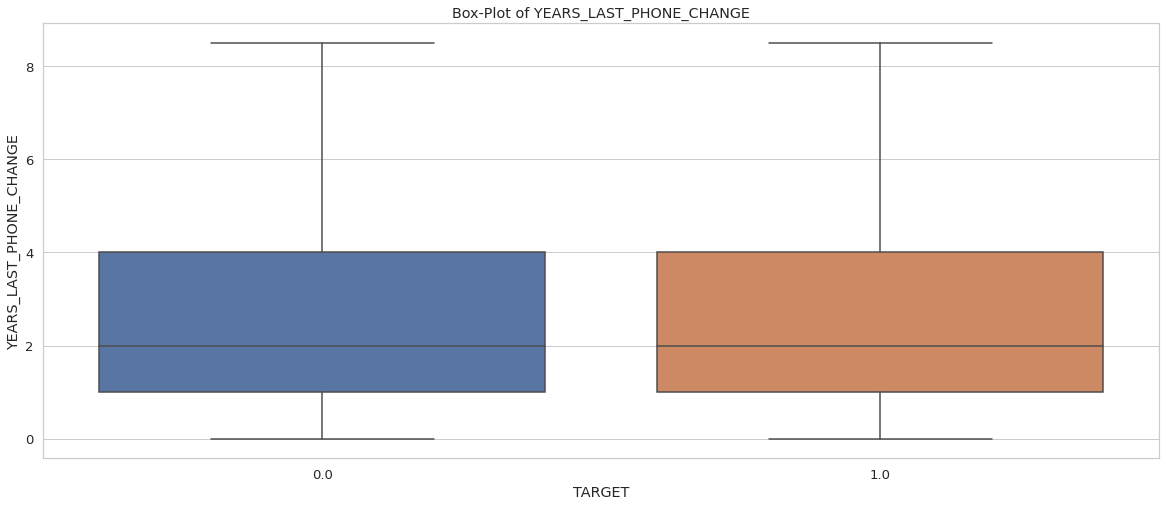

In [ ]:
for key, val in daysColumnsMapping.items():
    if val in data.columns:
        plot_column(data, val, ['box'])
    elif debug == True:
        print(val,"not found in dataframe: skipping plotting")

### Removing YEARS_LAST_PHONE_CHANGE

In [ ]:
data = data.drop('YEARS_LAST_PHONE_CHANGE', axis = 1)

### Showing remaining NaN
It would have been nice to do something clever with the categorical null values but I ran out of time.

In [ ]:
for i in list(data_continuous.columns):
    if i in data.columns:
        data[i] = data[i].fillna(data[i].mean())

In [ ]:
print("Data Null Values: \n", lineString)
print(data.isnull().sum()[data.isnull().sum() > data.shape[0] * .5])

Data Null Values: 
 ---------------------------------------------------------------------------------------------------------
Series([], dtype: int64)


In [ ]:
# Nicer list so we don't have to keep iterating through dictionaries
"""newYearsColumns = []
for key, val in daysColumnsMapping.items():
    if val in data.columns:
        newYearsColumns.append(val)

if 'filthyFinancialAggregate' not in data.columns:
    filthyFinancialMaturityAggregate = data[newYearsColumns].sum(axis=1)
    data.insert(len(data.columns), 'filthyFinancialAggregate', filthyFinancialMaturityAggregate)

plot_column(data, 'filthyFinancialAggregate', ['box'])"""

"newYearsColumns = []\nfor key, val in daysColumnsMapping.items():\n    if val in data.columns:\n        newYearsColumns.append(val)\n\nif 'filthyFinancialAggregate' not in data.columns:\n    filthyFinancialMaturityAggregate = data[newYearsColumns].sum(axis=1)\n    data.insert(len(data.columns), 'filthyFinancialAggregate', filthyFinancialMaturityAggregate)\n\nplot_column(data, 'filthyFinancialAggregate', ['box'])"

In [ ]:
#print(data['YEARS_REGISTRATION'].describe())
#showHeatmap(data)

### Removing Duplicates

#### Showing Currently No Duplicate Values

In [ ]:
# Breaks execution of code if there is a duplicate in the dataset which needs to be fixed
for i in data.duplicated():
    assert(i == False)

## Feature Engineering

### Financial Maturity
A client's financial maturity should have something to do with their age relative to how long they have been working, how long they have been registered, if they own realty or a car, and are working. 

In [ ]:
# Declare list of variables of interest in regards to financial maturity
financialMaturityColumns = ['YEARS_BIRTH',
                            'YEARS_EMPLOYED',
                            'YEARS_REGISTRATION',
                            'YEARS_ID_PUBLISH']
# Iterate through list and display their top 10 correlations
for i in financialMaturityColumns:
    if i in data:
        print(i, "Top 10 Correlation: ")
        print(data.corr()[i].abs().sort_values(ascending = False).head(11)[1:], end = "\n"+lineString+"\n")

YEARS_BIRTH Top 10 Correlation: 
YEARS_EMPLOYED              0.673066
FLAG_EMP_PHONE_1            0.619592
EXT_SOURCE_1                0.358379
YEARS_REGISTRATION          0.331287
CNT_CHILDREN                0.330812
CNT_FAM_MEMBERS             0.278752
YEARS_ID_PUBLISH            0.272916
REG_CITY_NOT_WORK_CITY_1    0.242271
EXT_SOURCE_3                0.181262
REG_CITY_NOT_LIVE_CITY_1    0.180341
Name: YEARS_BIRTH, dtype: float64
---------------------------------------------------------------------------------------------------------
YEARS_EMPLOYED Top 10 Correlation: 
FLAG_EMP_PHONE_1             0.888324
YEARS_BIRTH                  0.673066
REG_CITY_NOT_WORK_CITY_1     0.284989
YEARS_ID_PUBLISH             0.279604
YEARS_REGISTRATION           0.253732
CNT_CHILDREN                 0.240445
LIVE_CITY_NOT_WORK_CITY_1    0.228597
CNT_FAM_MEMBERS              0.219889
EXT_SOURCE_1                 0.202541
CODE_GENDER_M                0.179051
Name: YEARS_EMPLOYED, dtype: float64
----

#### Building Financial Maturity Variable

count    307511.000000
mean          0.372906
std           0.156988
min           0.000000
25%           0.254386
50%           0.370370
75%           0.480000
max           1.352273
Name: financialMaturity, dtype: float64


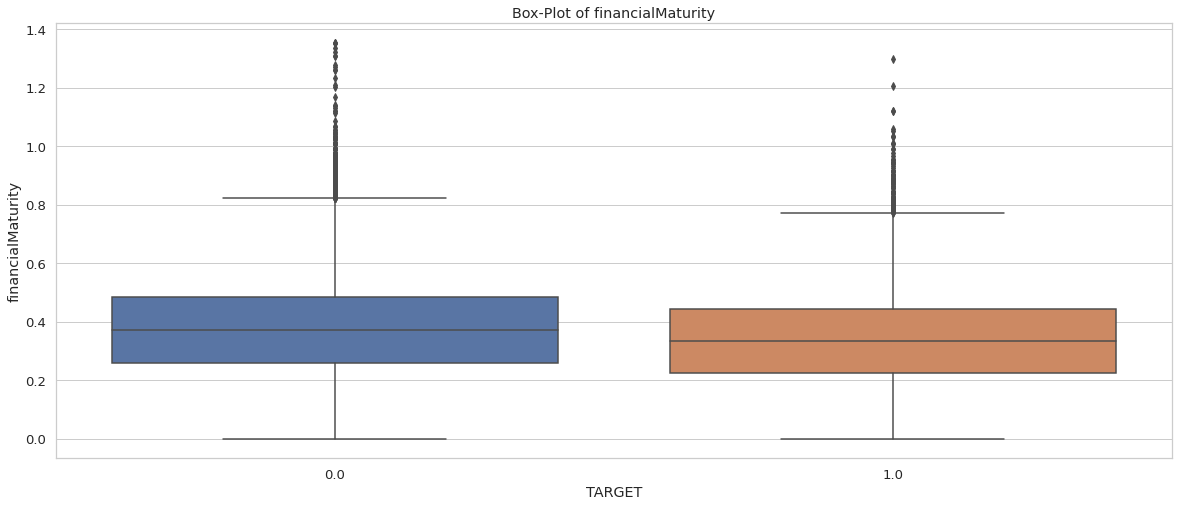

In [ ]:
if 'financialMaturity' not in data.columns:
    data['financialMaturity'] = ((data['YEARS_EMPLOYED'] + data['YEARS_REGISTRATION'] + data['YEARS_ID_PUBLISH'])/2)/data['YEARS_BIRTH']
print(data['financialMaturity'].describe())
plot_column(data, 'financialMaturity', ['box'])

#### Removing Remaining Financial Maturity Variables

In [ ]:
for i in financialMaturityColumns:
    if i in data.columns:
        data.drop(i, axis = 1, inplace = True)
print(data.shape)

(307511, 82)


### External Credit Source Aggregate
EXT_SOURCE1, 2, 3 have the highest correlation with data and high correlations with eachother as well. For now we will create an average external source that we create.

#### External Source List and Correlations
While the ext sources do not have particularly high correlations with any unexpected variables, we must note that there still remains some correlation between the region and the external source variables, which should be of note.

In [ ]:
extCols = ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']

# Iterate through list and display their top 10 correlations
for i in extCols:
    if i in data:
        print(i, "Top 10 Correlation: ")
        print(data.corr()[i].abs().sort_values(ascending = False).head(11)[1:], end = "\n"+lineString+"\n")

EXT_SOURCE_1 Top 10 Correlation: 
CODE_GENDER_M               0.198722
FLAG_EMP_PHONE_1            0.148872
EXT_SOURCE_2                0.135721
REG_CITY_NOT_WORK_CITY_1    0.126052
AMT_GOODS_PRICE             0.119576
AMT_CREDIT                  0.114473
EXT_SOURCE_3                0.110606
REG_CITY_NOT_LIVE_CITY_1    0.099524
TARGET                      0.099152
CNT_CHILDREN                0.096844
Name: EXT_SOURCE_1, dtype: float64
---------------------------------------------------------------------------------------------------------
EXT_SOURCE_2 Top 10 Correlation: 
REGION_RATING_CLIENT           0.292610
REGION_RATING_CLIENT_W_CITY    0.288015
REGION_POPULATION_RELATIVE     0.198706
TARGET                         0.160303
AMT_GOODS_PRICE                0.139209
EXT_SOURCE_1                   0.135721
AMT_CREDIT                     0.131129
AMT_ANNUITY                    0.125702
EXT_SOURCE_3                   0.096653
FLOORSMAX_AVG                  0.093346
Name: EXT_SOURCE_2, d

count    307511.000000
mean          0.509125
std           0.108183
min           0.023705
25%           0.439045
50%           0.518525
75%           0.584838
max           0.853417
Name: avgExt, dtype: float64


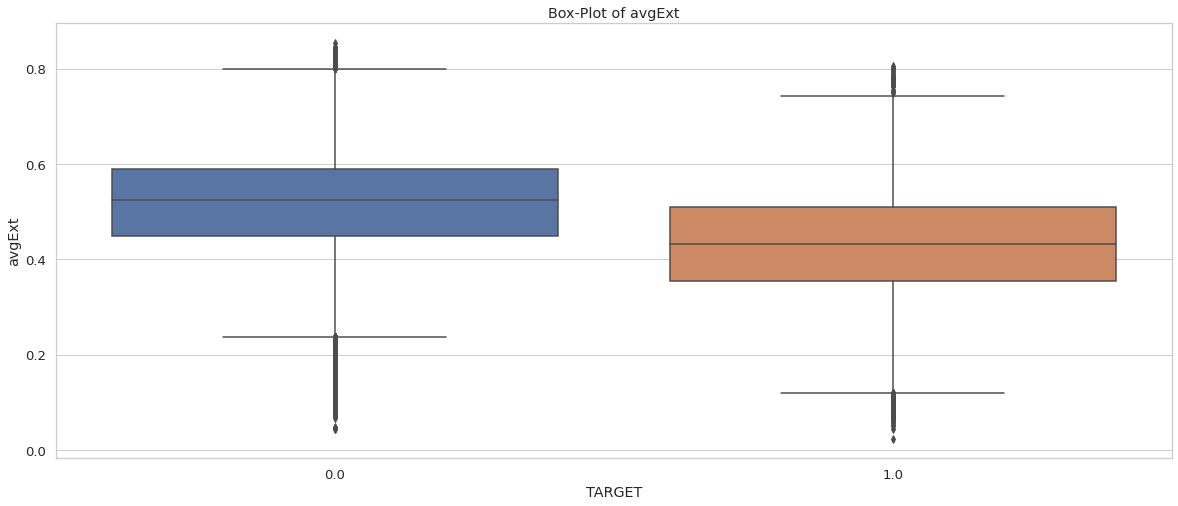

In [ ]:
if 'avgExt' not in data.columns:
    data['avgExt'] = ((data['EXT_SOURCE_1'] + data['EXT_SOURCE_2'] + data['EXT_SOURCE_3'])/3)
print(data['avgExt'].describe())
plot_column(data, 'avgExt', ['box'])

#### Removing EXT_SOURCE_1, 2, 3

In [ ]:
for i in extCols:
    if i in data.columns:
        data.drop(i, axis = 1, inplace = True)
print(data.shape)

(307511, 80)


### Loan Weight

A feature that may be useful to extract in regards to reducing dimensionality is a loan weight, taking in a function of the credit, annuity as some ratio to the relative price of goods. From here we can also make some adjustments based on the client's total income and possibly income type. 

It's quite painful to see from a data analysis perspective that the total income is very much correlated with the user gender.

In [ ]:
def describeCorrelation(list):
    for i in list:
        if i in data:
            print(i, "Top 10 Correlations: ")
            print(data.corr()[i].abs().sort_values(ascending = False).head(11)[1:], end = "\n"+lineString+"\n")

loanWeightCols = [
    "AMT_INCOME_TOTAL",
    "AMT_CREDIT",
    "AMT_ANNUITY",
    "AMT_GOODS_PRICE",
    "CNT_FAM_MEMBERS"
]

# Iterate through list and display their top 10 correlations
describeCorrelation(loanWeightCols)

AMT_INCOME_TOTAL Top 10 Correlations: 
AMT_ANNUITY                    0.191657
AMT_GOODS_PRICE                0.159600
AMT_CREDIT                     0.156870
REGION_RATING_CLIENT_W_CITY    0.091735
REGION_RATING_CLIENT           0.085465
FLAG_OWN_CAR_Y                 0.083383
REGION_POPULATION_RELATIVE     0.074796
CODE_GENDER_M                  0.074730
FLAG_EMP_PHONE_1               0.063994
REG_REGION_NOT_WORK_REGION     0.062340
Name: AMT_INCOME_TOTAL, dtype: float64
---------------------------------------------------------------------------------------------------------
AMT_CREDIT Top 10 Correlations: 
AMT_GOODS_PRICE                       0.986588
AMT_ANNUITY                           0.770127
NAME_CONTRACT_TYPE_Revolving loans    0.221648
AMT_INCOME_TOTAL                      0.156870
avgExt                                0.147341
FLAG_OWN_CAR_Y                        0.116225
REGION_RATING_CLIENT_W_CITY           0.110915
REGION_RATING_CLIENT                  0.101776
REGION_

count    307511.000000
mean         30.653439
std          30.946006
min           0.031483
25%           9.247519
50%          21.070706
75%          41.658092
max        1019.352434
Name: loanWeight, dtype: float64


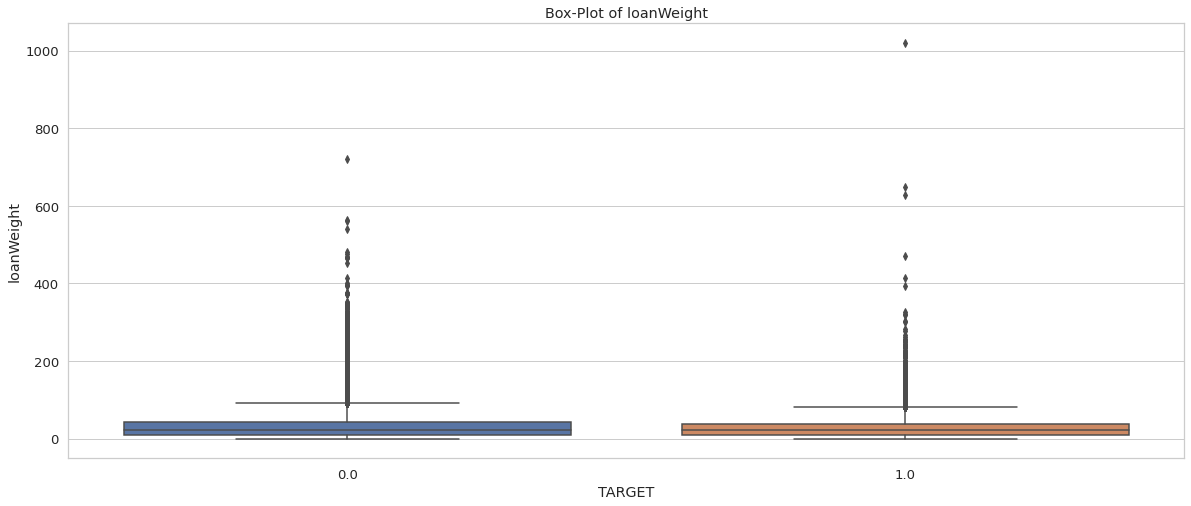

In [ ]:
if 'loanWeight' not in data.columns:
    data['loanWeight'] = data['AMT_CREDIT'] / 4000 * ((data['AMT_ANNUITY']) / (data['AMT_INCOME_TOTAL']))
print(data['loanWeight'].describe())
plot_column(data, 'loanWeight', ['box'])

In [ ]:
for i in loanWeightCols:
    if i in data.columns:
        data.drop(i, axis = 1, inplace = True)
print(data.shape)

(307511, 76)


In [ ]:
from sklearn.preprocessing import StandardScaler # Used for standardizing data for PCA and K-means clustering

houseValueCols = [
    'APARTMENTS_AVG',
    'COMMONAREA_AVG',
    'ENTRANCES_AVG',
    'FLOORSMAX_AVG',
    'FLOORSMIN_AVG',
    'LANDAREA_AVG',
    'LIVINGAPARTMENTS_AVG',
    'LIVINGAREA_AVG',
]

# K-means has difficulty computing distance with different scaling - this normalizes
scaler = StandardScaler()
scaled_features = scaler.fit_transform(data[houseValueCols])
data[houseValueCols].describe()

,APARTMENTS_AVG,COMMONAREA_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG
count,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000,307511.000000
mean,0.117440,0.044621,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399
std,0.075961,0.041735,0.070498,0.102521,0.091506,0.051743,0.052078,0.078030
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.089700,0.044621,0.137900,0.166700,0.231894,0.062900,0.100775,0.074800
50%,0.117440,0.044621,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399
75%,0.117440,0.044621,0.149725,0.226282,0.231894,0.066333,0.100775,0.107399
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Just calculate the weighted average of the normalized housing attributes for now
weightedAvgs = []
for i in scaled_features:
    weightedAvgs.append(sum(i)*.1/len(i))

count    3.075110e+05
mean     6.224247e-18
std      7.076355e-02
min     -1.754385e-01
25%     -2.219481e-02
50%      7.281040e-18
75%      7.281040e-18
max      1.141960e+00
Name: homeValue, dtype: float64


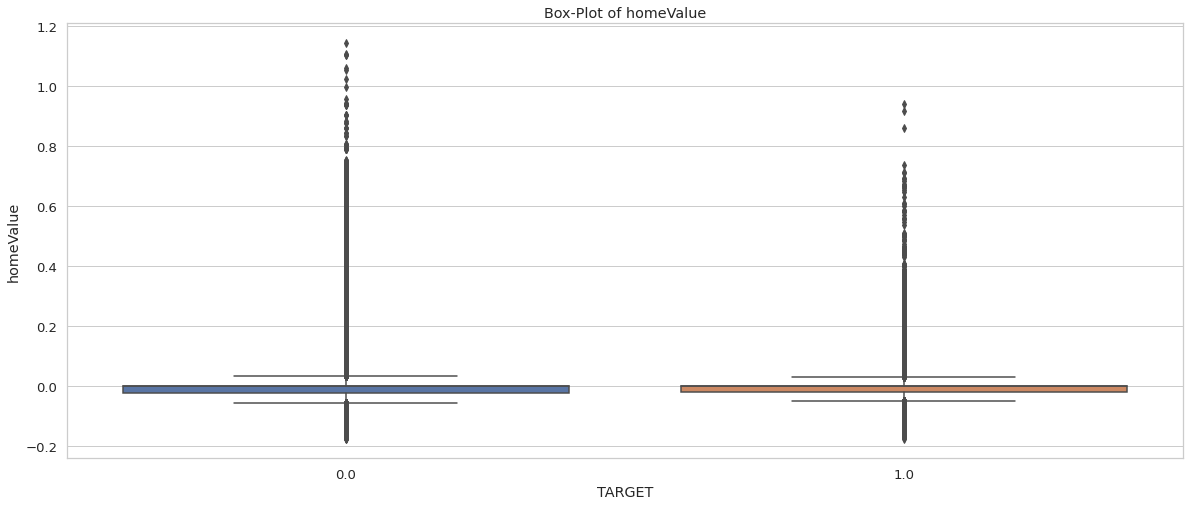

In [ ]:
if 'homeValue' not in data.columns:
    data['homeValue'] = weightedAvgs
print(data['homeValue'].describe())
plot_column(data, 'homeValue', ['box'])

In [ ]:
landColsToDrop = [
    'APARTMENTS_AVG',
    'BASEMENTAREA_AVG',
    'YEARS_BEGINEXPLUATATION_AVG',
    'YEARS_BUILD_AVG',
    'COMMONAREA_AVG',
    'ELEVATORS_AVG',
    'ENTRANCES_AVG',
    'FLOORSMAX_AVG',
    'FLOORSMIN_AVG',
    'LANDAREA_AVG',
    'LIVINGAPARTMENTS_AVG',
    'LIVINGAREA_AVG',
    'APARTMENTS_MODE',
    'BASEMENTAREA_MODE',
    'YEARS_BEGINEXPLUATATION_MODE',
    'YEARS_BUILD_MODE',
    'COMMONAREA_MODE',
    'ELEVATORS_MODE',
    'ENTRANCES_MODE',
    'FLOORSMAX_MODE',
    'FLOORSMIN_MODE',
    'LANDAREA_MODE',
    'LIVINGAPARTMENTS_MODE',
    'LIVINGAREA_MODE',
    'LIVINGAPARTMENTS_MEDI',
    'APARTMENTS_MEDI',
    'BASEMENTAREA_MEDI',
    'YEARS_BEGINEXPLUATATION_MEDI',
    'YEARS_BUILD_MEDI',
    'COMMONAREA_MEDI',
    'ELEVATORS_MEDI',
    'ENTRANCES_MEDI',
    'FLOORSMAX_MEDI',
    'FLOORSMIN_MEDI',
    'LANDAREA_MEDI',
    'LIVINGAREA_MEDI',
    'TOTALAREA_MODE'
]

for col in landColsToDrop:
    if col in data.columns:
        data.drop(col, axis = 1, inplace = True)

if debug == True:
    print(data.shape)

(307511, 40)


In [ ]:
obsList = [
    'OBS_30_CNT_SOCIAL_CIRCLE',
    'DEF_30_CNT_SOCIAL_CIRCLE',
    'OBS_60_CNT_SOCIAL_CIRCLE',
    'DEF_60_CNT_SOCIAL_CIRCLE',
]

describeCorrelation(obsList)

OBS_30_CNT_SOCIAL_CIRCLE Top 10 Correlations: 
OBS_60_CNT_SOCIAL_CIRCLE         0.998490
DEF_30_CNT_SOCIAL_CIRCLE         0.329338
DEF_60_CNT_SOCIAL_CIRCLE         0.253499
REGION_RATING_CLIENT             0.034256
AMT_REQ_CREDIT_BUREAU_YEAR       0.030468
REGION_RATING_CLIENT_W_CITY      0.030030
REG_REGION_NOT_WORK_REGION       0.028798
LIVE_REGION_NOT_WORK_REGION_1    0.023091
REG_REGION_NOT_LIVE_REGION_1     0.020607
homeValue                        0.019498
Name: OBS_30_CNT_SOCIAL_CIRCLE, dtype: float64
---------------------------------------------------------------------------------------------------------
DEF_30_CNT_SOCIAL_CIRCLE Top 10 Correlations: 
DEF_60_CNT_SOCIAL_CIRCLE         0.860517
OBS_60_CNT_SOCIAL_CIRCLE         0.331571
OBS_30_CNT_SOCIAL_CIRCLE         0.329338
avgExt                           0.043461
TARGET                           0.032222
CODE_GENDER_M                    0.017992
REG_REGION_NOT_WORK_REGION       0.017445
AMT_REQ_CREDIT_BUREAU_YEAR       0.0172

count    3.075110e+05
mean    -4.141796e-18
std      7.928589e-02
min     -4.457640e-02
25%     -4.457640e-02
50%     -4.457640e-02
75%      1.828048e-02
max      1.076964e+01
Name: obs, dtype: float64


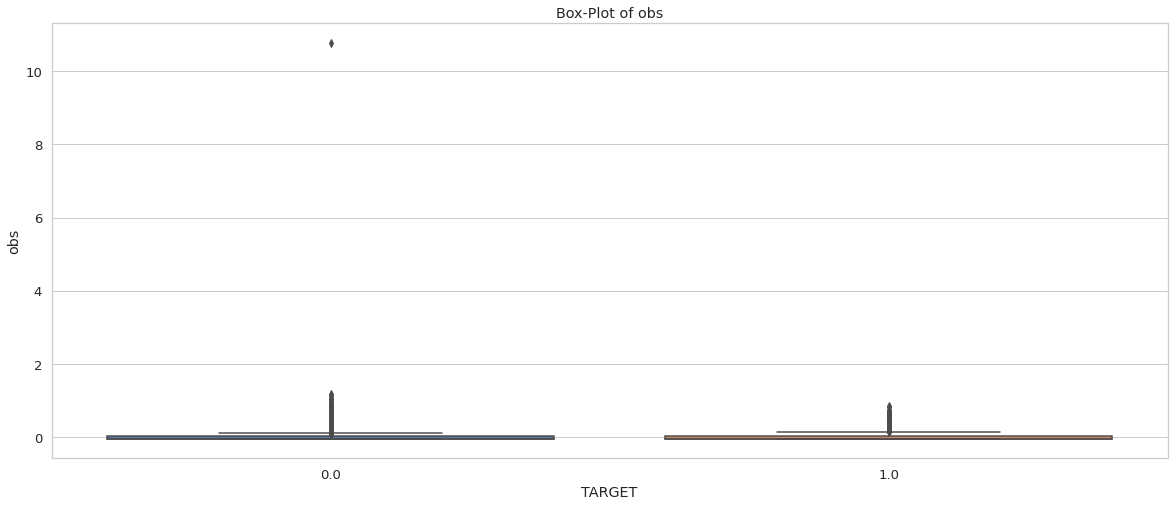

In [ ]:
scaled_features = scaler.fit_transform(data[obsList])
# Just calculate the weighted average of the normalized housing attributes for now
weightedAvgs = []
for i in scaled_features:
    weightedAvgs.append(sum(i)*.1/len(i))
if 'obs' not in data.columns:
    data['obs'] = weightedAvgs
print(data['obs'].describe())
plot_column(data, 'obs', ['box'])

In [ ]:
for col in obsList:
    if col in data.columns:
        data.drop(col, axis = 1, inplace = True)
        
if debug == True:
    print(data.shape)

(307511, 37)


In [ ]:
data.drop('SK_ID_CURR', axis = 1, inplace = True)

for i in data.columns:
    print(data[i].describe())

count    307511.000000
mean          0.080729
std           0.272419
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: TARGET, dtype: float64
count    307511.000000
mean          0.417052
std           0.722121
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max          19.000000
Name: CNT_CHILDREN, dtype: float64
count            307511
unique                7
top       Unaccompanied
freq             249818
Name: NAME_TYPE_SUITE, dtype: object
count      307511
unique          8
top       Working
freq       158774
Name: NAME_INCOME_TYPE, dtype: object
count                            307511
unique                                5
top       Secondary / secondary special
freq                             218391
Name: NAME_EDUCATION_TYPE, dtype: object
count      307511
unique          5
top       Married
freq       196434
Name: NAME_FAMILY_STATUS, dtype: object
count       

### Normalizing Data

In [ ]:
# Select any string/object columns to encode if there are any left
dummiesCols = list(data.select_dtypes(include='object').columns)
# Generate dummy data frame
dum_df = pd.get_dummies(data, columns = dummiesCols, prefix="encoded_")
if debug == True:
    print(dum_df.shape)

print(dum_df.columns)
# Normalize remaining data
scaler=MinMaxScaler()
#dum_df = pd.DataFrame(scaler.fit_transform(dum_df))
scaled = scaler.fit_transform(dum_df)
print(scaled)
dum_df = pd.DataFrame(scaled, columns = dum_df.columns)

# Split dataset into features and labels
features = dum_df.drop(targetColumnName, axis = 1)
labels = dum_df[targetColumnName]

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.7, random_state=1)

# Create random tree forest
model = RandomForestClassifier(n_estimators=100, random_state=1)

# Create Decision Tree classifer object
clf = DecisionTreeClassifier(criterion="entropy")
clf = clf.fit(X_train, y_train)

# Predict the response for test dataset
y_pred = clf.predict(X_test)
# Model Accuracy, how often is the classifier correct?
print("Accuracy of single decision tree:",metrics.accuracy_score(y_test, y_pred))

(307511, 88)
Index(['TARGET', 'CNT_CHILDREN', 'REGION_POPULATION_RELATIVE', 'OWN_CAR_AGE',
       'REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY',
       'REG_REGION_NOT_WORK_REGION', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK',
       'AMT_REQ_CREDIT_BUREAU_MON', 'AMT_REQ_CREDIT_BUREAU_QRT',
       'AMT_REQ_CREDIT_BUREAU_YEAR', 'CODE_GENDER_M', 'FLAG_EMP_PHONE_1',
       'LIVE_CITY_NOT_WORK_CITY_1', 'NAME_CONTRACT_TYPE_Revolving loans',
       'FLAG_OWN_CAR_Y', 'FLAG_OWN_REALTY_Y', 'REG_REGION_NOT_LIVE_REGION_1',
       'LIVE_REGION_NOT_WORK_REGION_1', 'REG_CITY_NOT_LIVE_CITY_1',
       'REG_CITY_NOT_WORK_CITY_1', 'financialMaturity', 'avgExt', 'loanWeight',
       'homeValue', 'obs', 'encoded__Children', 'encoded__Family',
       'encoded__Group of people', 'encoded__Other_A', 'encoded__Other_B',
       'encoded__Spouse, partner', 'encoded__Unaccompanied',
       'encoded__Businessman', 'encoded__Commercial associate',
       '

In [ ]:
print(metrics.balanced_accuracy_score(y_test, y_pred))
print(metrics.average_precision_score(y_test, y_pred))
print(metrics.precision_score(y_test, y_pred))

0.5340213521273762
0.08927177879279004
0.13676447836625238


In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Performs 10 runs of K-means algorithm with 3 clusters and maximum of 300 iterations.
kmeansArgs = {
    "init" : "k-means++",   # Both have been tried - optimal to intelligently initialize centroids
    "n_init" : 10,                 # Performs 10 runs
    "max_iter" : 300,              # At most 300 iterations - usually doesn't go through too many
    "random_state" : 42
}

# After visualization we save our k-means data structure with optimal number of clusters
kmeans = KMeans(n_clusters=4, **kmeansArgs)
y_predict= kmeans.fit_predict(X_test)

# Print out test predictions
print(metrics.balanced_accuracy_score(y_test, y_predict))
print(metrics.average_precision_score(y_test, y_predict))


0.16609811967590615
0.09952045046202843


/home/feeks/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1999: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")


In [ ]:
# Import hierarchical clustering libraries
from scipy.cluster.hierarchy import dendrogram, linkage
import scipy.cluster.hierarchy as sc
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as shc

numClusters = 4

# Perform Agglomerative Clustering for the given number of clusters
#dataArr = data.values #df_num.iloc[:,:].values
cluster = AgglomerativeClustering(n_clusters=numClusters, affinity='euclidean', linkage='ward')
cluster.fit_predict(dum_df.select_dtypes(include='float64'))

MemoryError: Unable to allocate 352. GiB for an array with shape (47281353805,) and data type float64